In [1]:
from env import get_db_url
import numpy as np
import pandas as pd
import os
import acquire
import prepare
import wrangle
import matplotlib.pyplot as plt
from scipy import stats
import sklearn.preprocessing
from sklearn.model_selection import train_test_split
import pandas as pd
import seaborn as sns
import explore
import pydataset
from math import sqrt

from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE

from sklearn.feature_selection import SelectKBest, f_regression

from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score

from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.preprocessing import PolynomialFeatures

In [2]:
zillow_predictions_unwrangled = acquire.get_zillow_predictions()
zillow_predictions_unwrangled

,bedroomcnt,bathroomcnt,calculatedfinishedsquarefeet,taxvaluedollarcnt,yearbuilt,taxamount,fips
0,4.0,3.5,3100.0,1023282.0,1998.0,11013.72,6059.0
1,2.0,1.0,1465.0,464000.0,1967.0,5672.48,6111.0
2,3.0,2.0,1243.0,564778.0,1962.0,6488.30,6059.0
3,4.0,3.0,2376.0,145143.0,1970.0,1777.51,6037.0
4,4.0,3.0,2962.0,773303.0,1950.0,9516.26,6037.0
...,...,...,...,...,...,...,...
52437,2.0,2.0,1286.0,354621.0,1940.0,4478.43,6037.0
52438,4.0,2.0,1612.0,67205.0,1964.0,1107.48,6111.0
52439,3.0,1.0,1032.0,49546.0,1954.0,876.43,6037.0
52440,3.0,2.0,1762.0,522000.0,1955.0,6317.15,6037.0


In [18]:
zillow_predictions = wrangle.wrangle_zillow_predictions()
zillow_dummies = pd.get_dummies(zillow_predictions['fips'])
zillow_dummies = zillow_dummies.rename(columns={6037.0 : "Los Angeles", 6059.0 : "Orange", 6111.0 : "Ventura"})
zillow_predictions = pd.concat([zillow_predictions, zillow_dummies], axis=1).drop(columns='fips')
zillow_predictions.isna().sum()


bedrooms       0
bathrooms      0
sqft           0
tax_value      0
year_built     0
tax_amount     0
Los Angeles    0
Orange         0
Ventura        0
dtype: int64

In [21]:
train, validate, test = prepare.split_data(zillow_predictions)
train

# KEEP JUST IN CASE
# train, validate, test = prepare.split_data(wrangle.wrangle_zillow_predictions())
# train

,bedrooms,bathrooms,sqft,tax_value,year_built,tax_amount,Los Angeles,Orange,Ventura
3958,3.0,2.0,1600.0,409260.0,1959.0,4968.19,1,0,0
38332,2.0,1.0,1638.0,126907.0,1927.0,1500.66,1,0,0
32297,4.0,2.0,1725.0,592000.0,1966.0,7380.59,1,0,0
31139,2.0,1.0,1015.0,172499.0,1925.0,2252.18,1,0,0
20188,1.0,1.0,565.0,292368.0,1915.0,3624.67,1,0,0
...,...,...,...,...,...,...,...,...,...
35558,4.0,4.0,4226.0,613350.0,1959.0,6464.74,0,0,1
8268,3.0,2.0,1534.0,380623.0,1970.0,4731.33,1,0,0
2175,2.0,1.5,1213.0,431697.0,1956.0,5451.26,0,1,0
11049,3.0,2.0,1584.0,271747.0,1959.0,3386.08,1,0,0


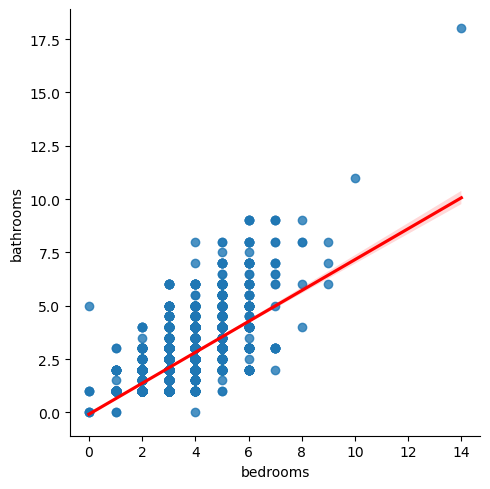

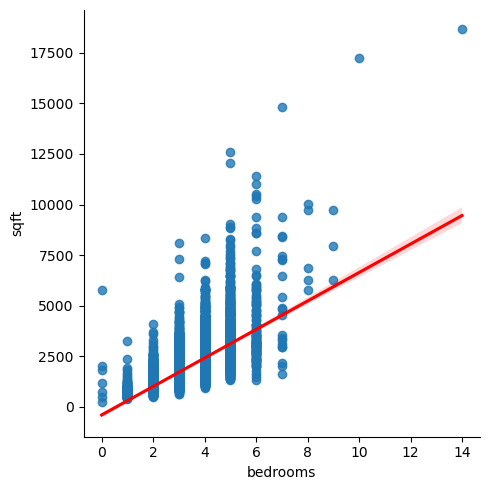

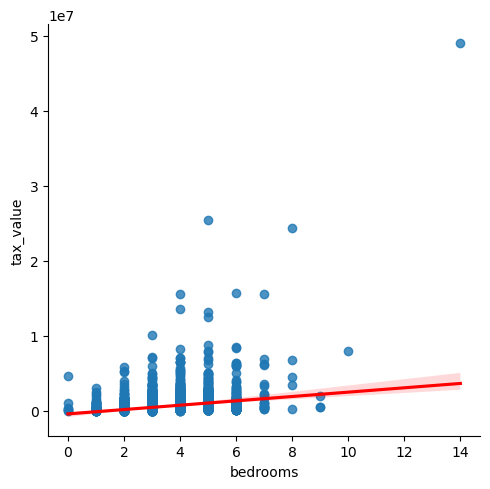

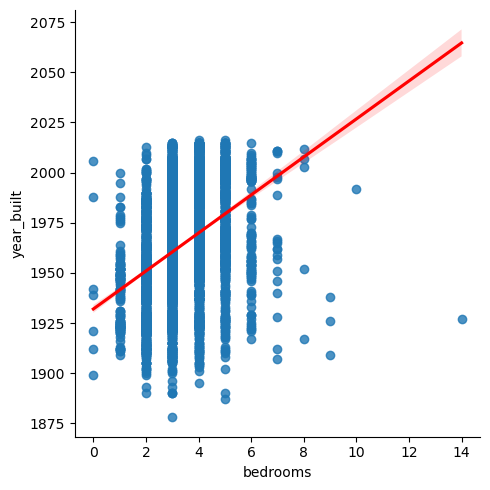

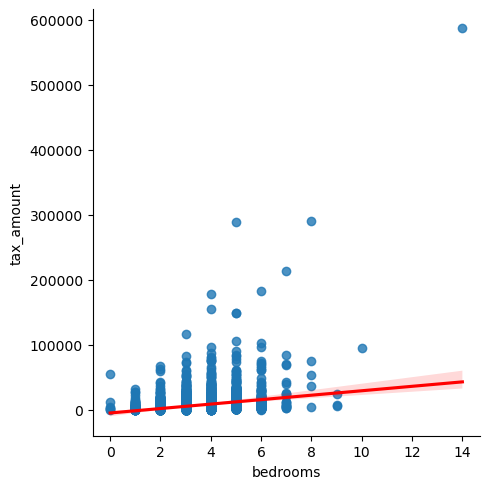

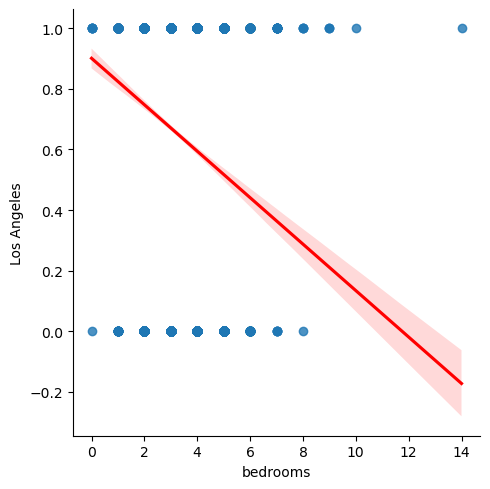

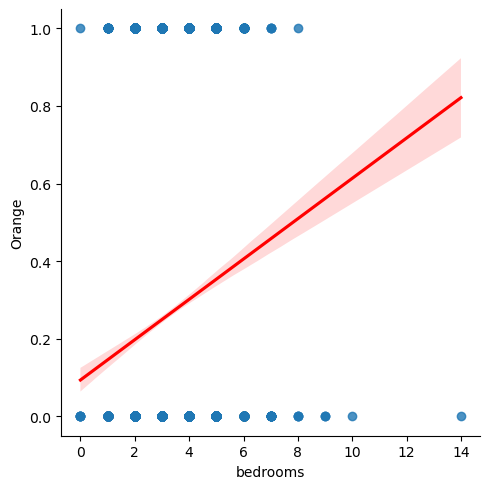

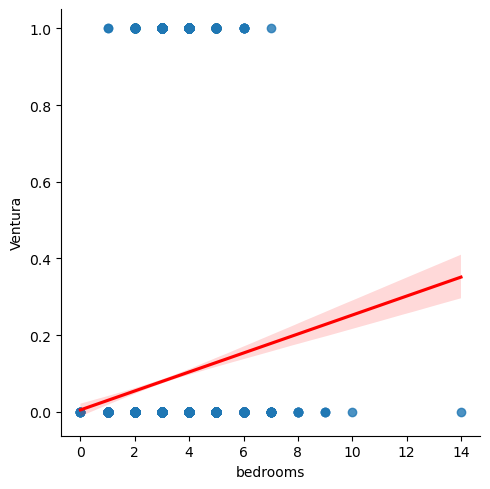

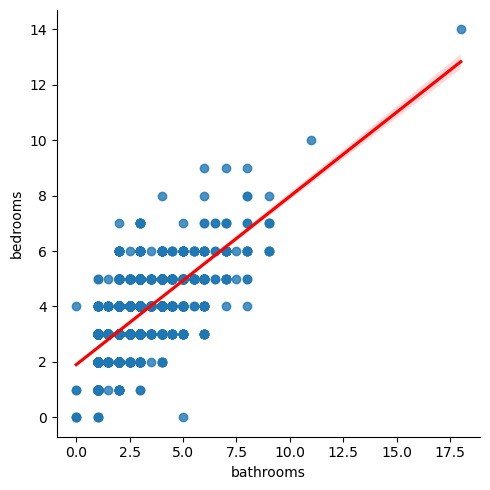

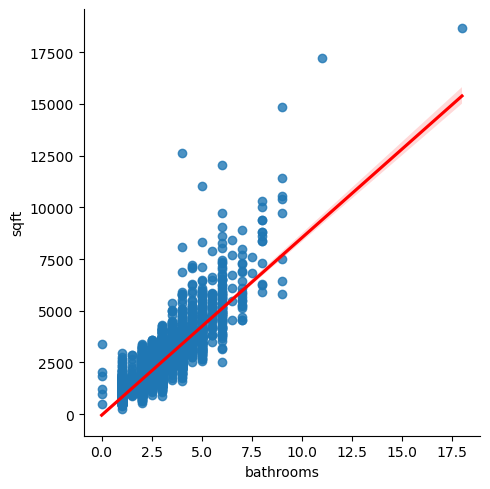

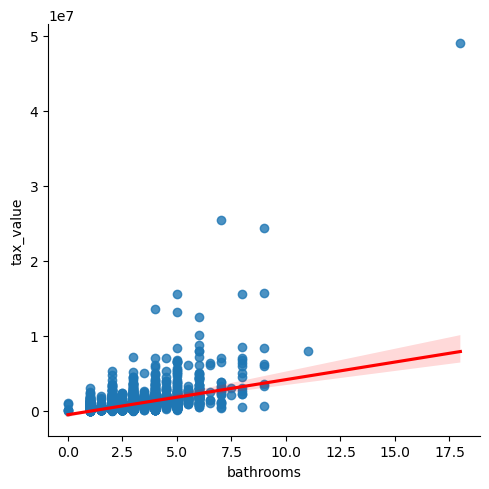

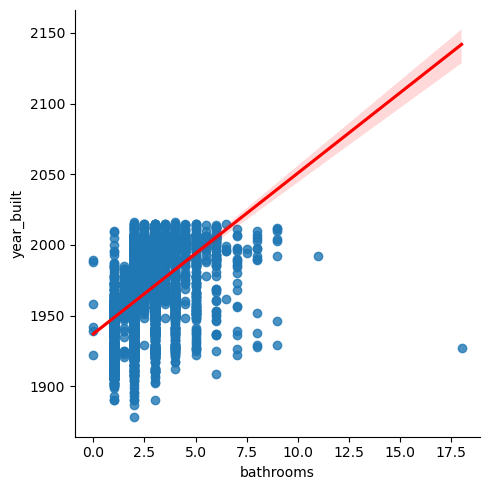

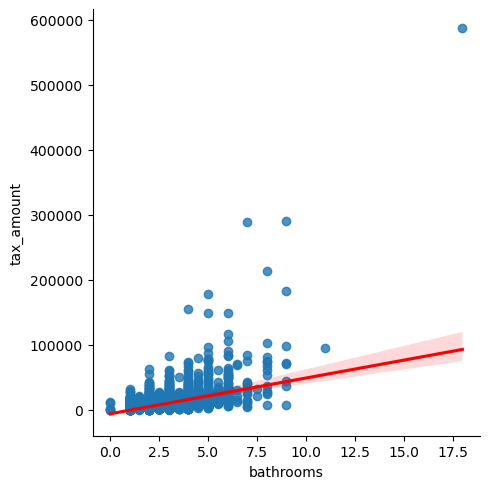

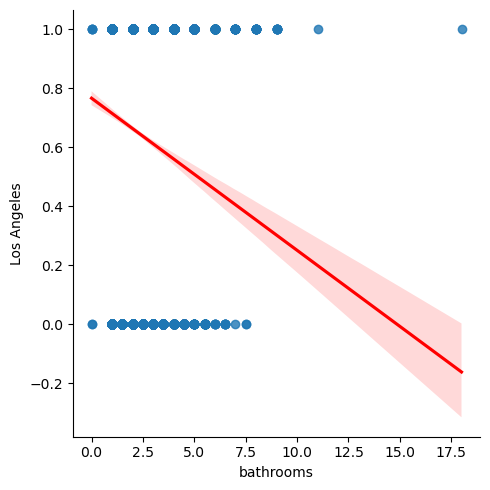

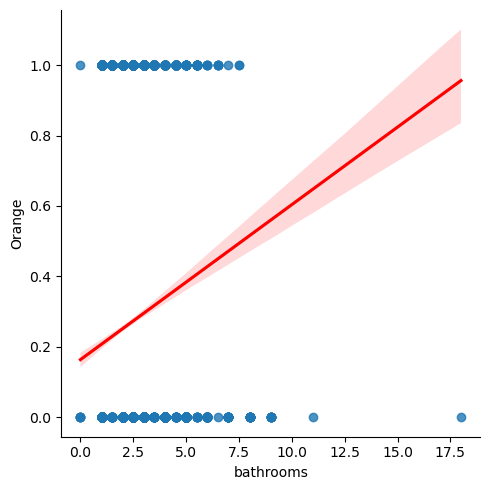

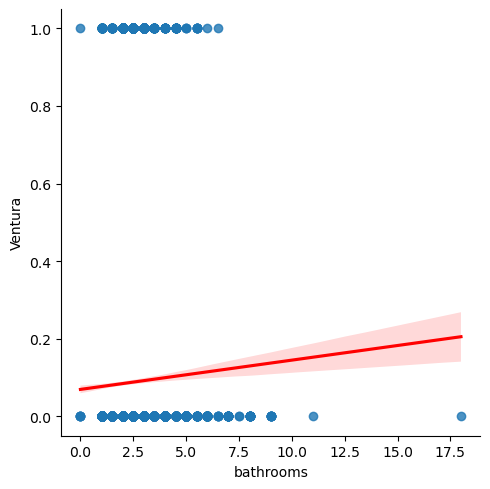

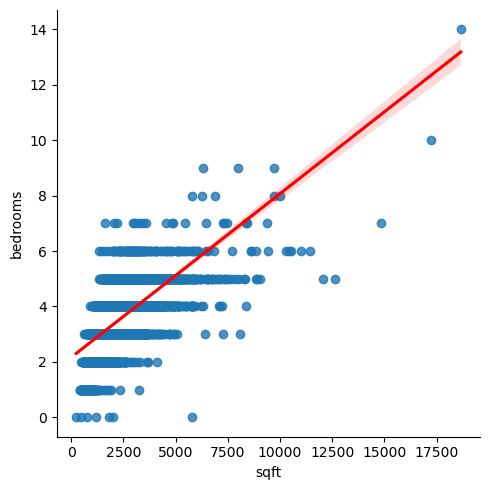

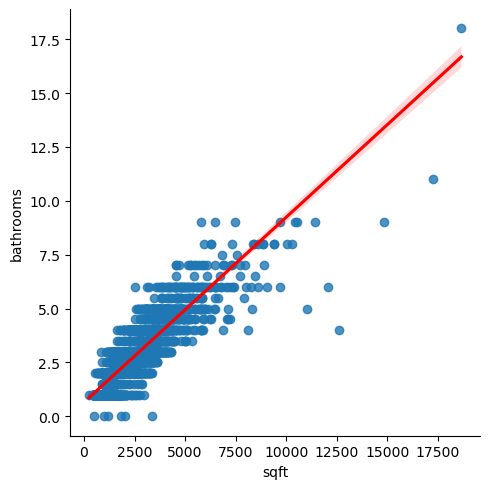

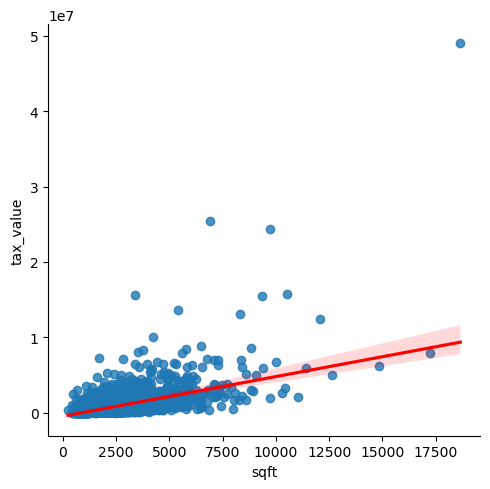

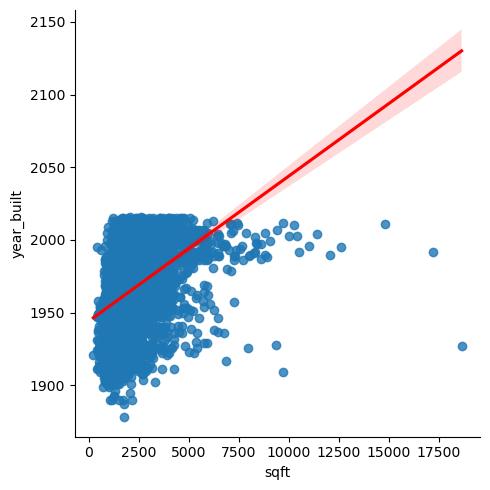

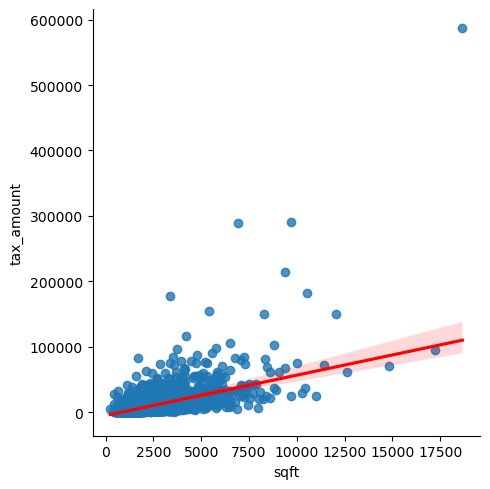

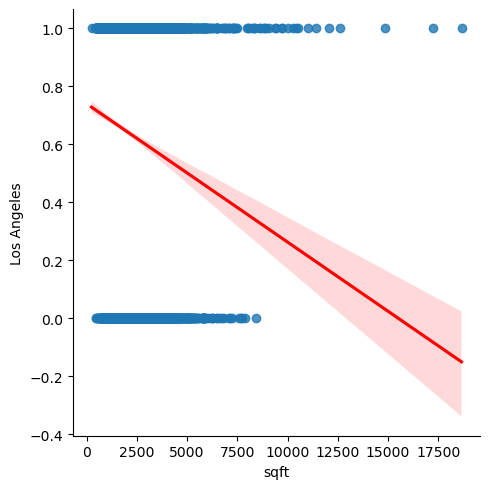

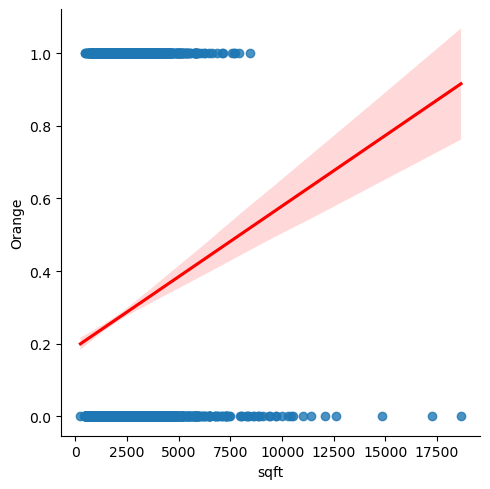

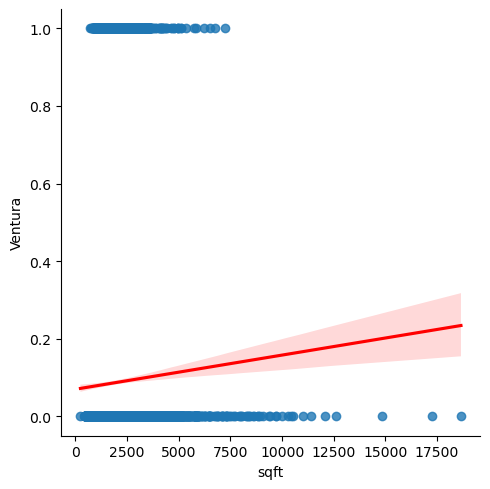

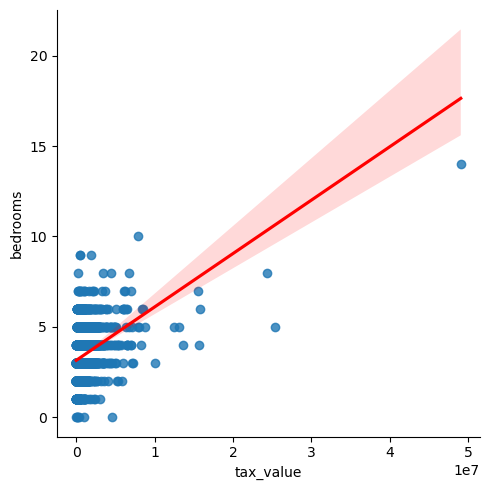

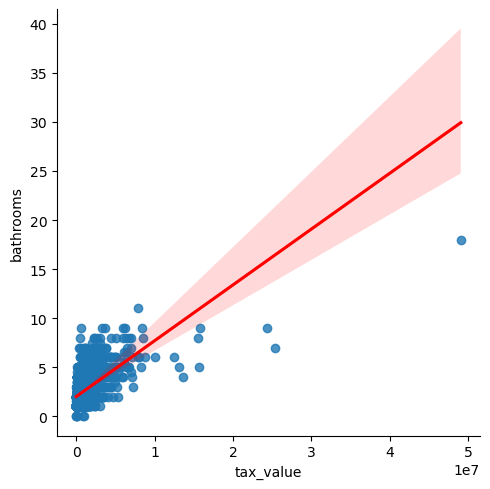

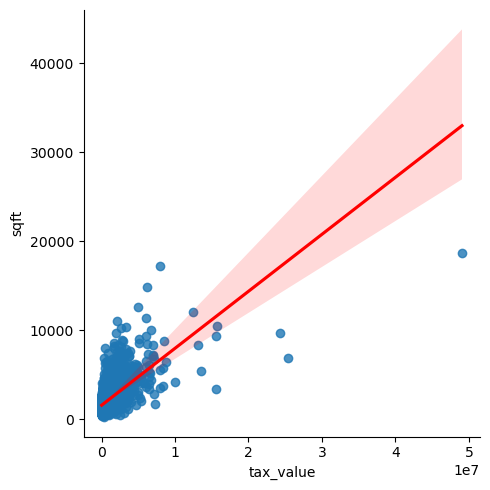

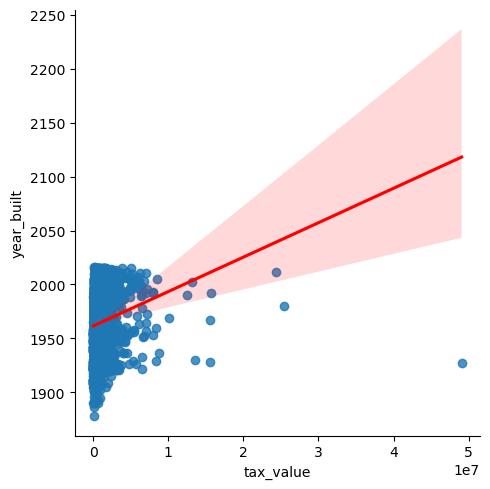

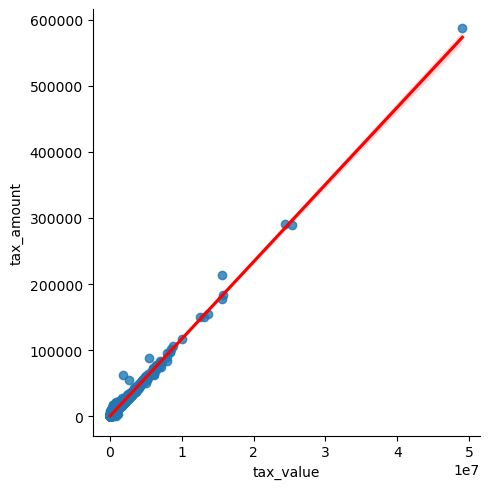

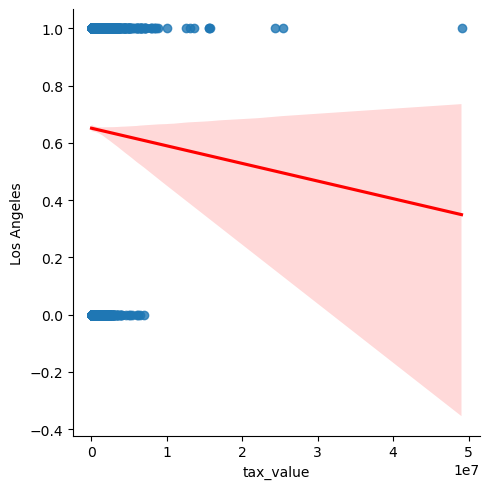

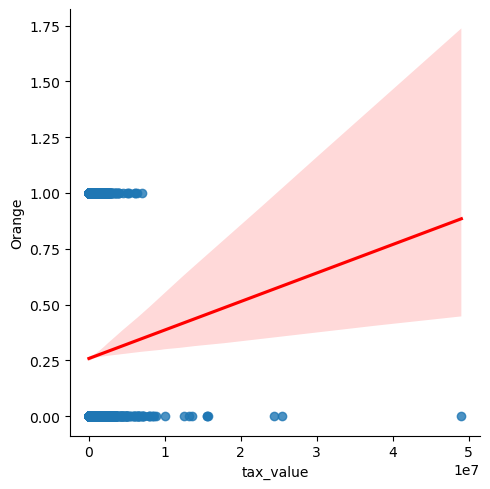

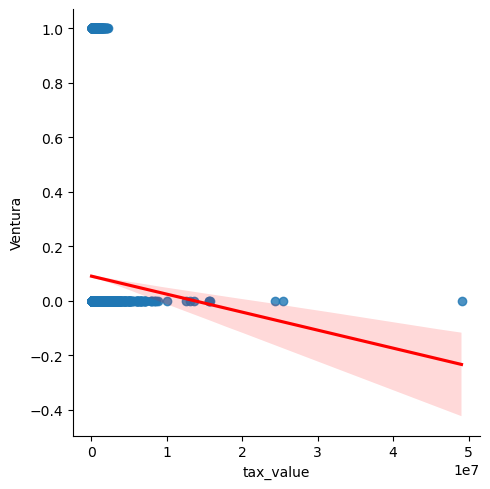

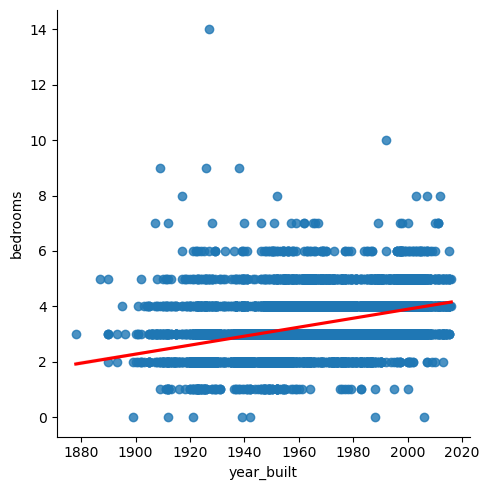

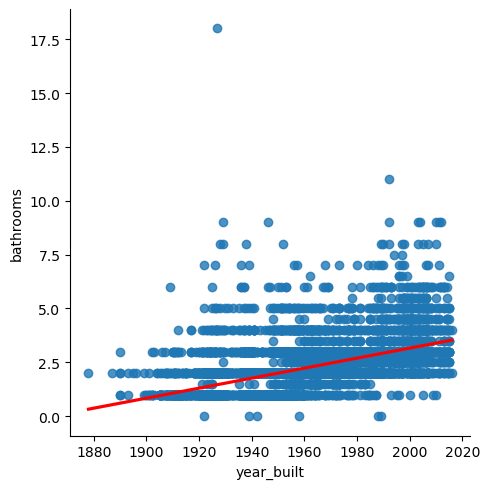

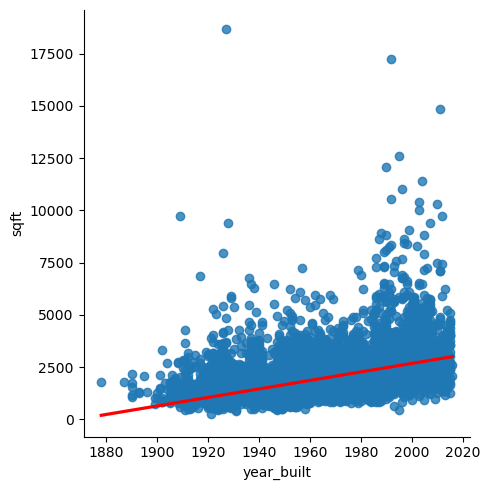

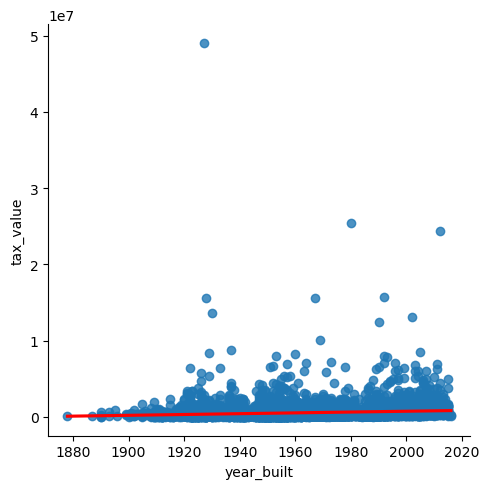

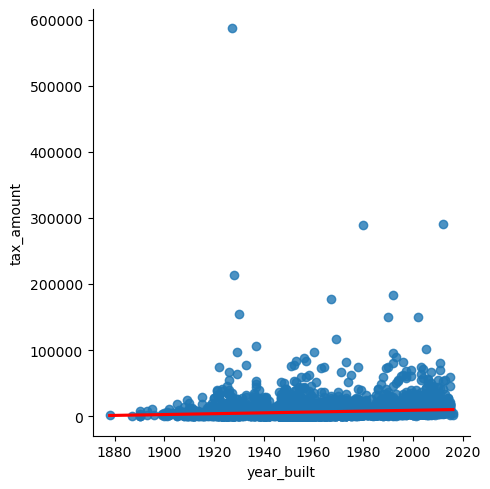

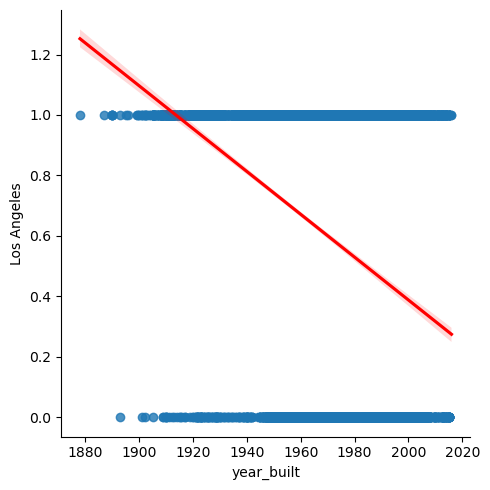

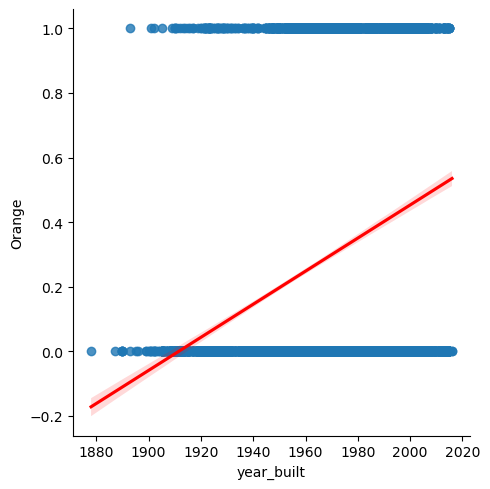

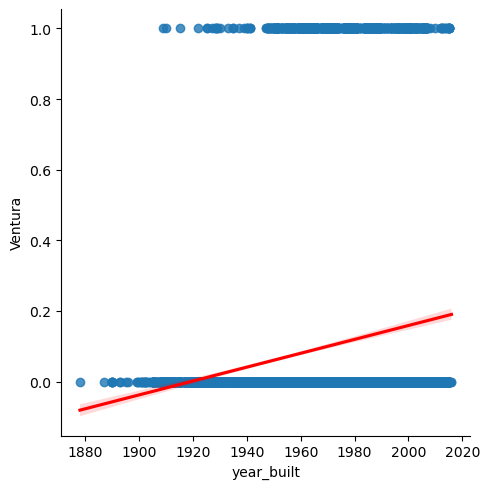

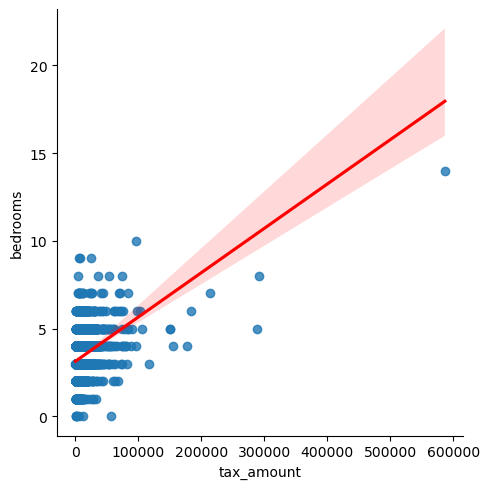

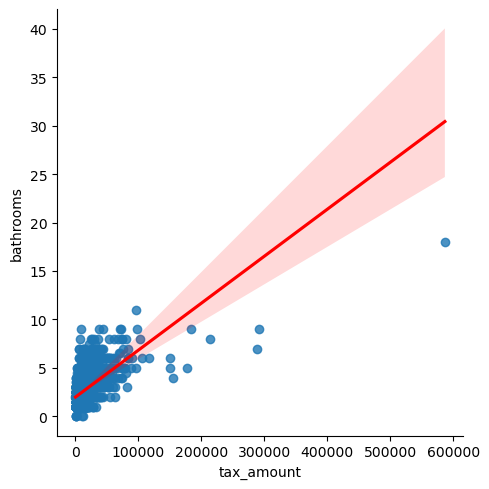

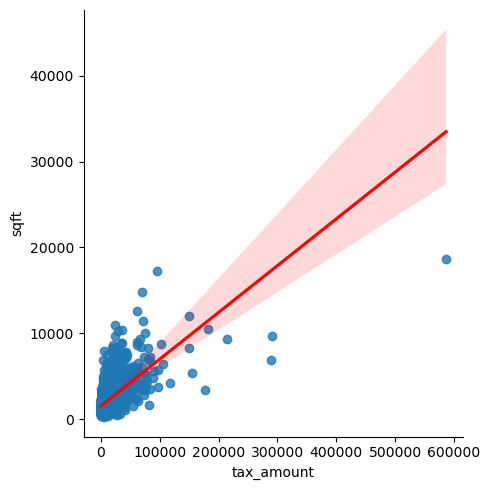

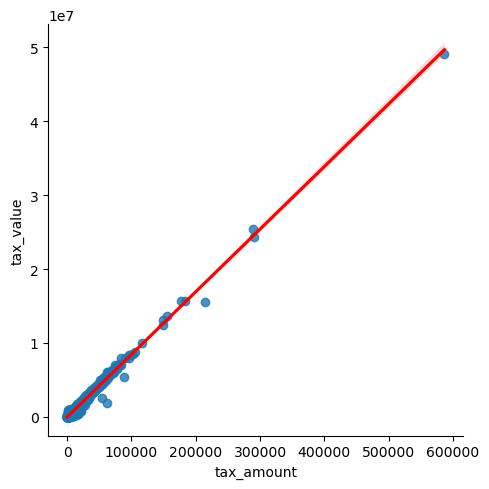

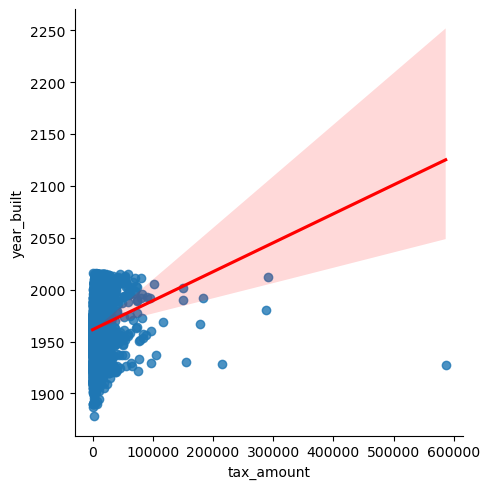

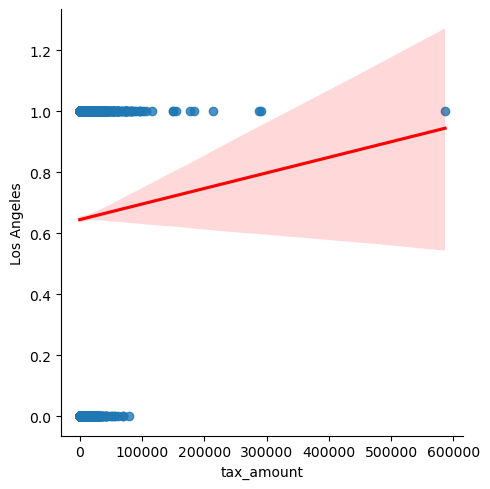

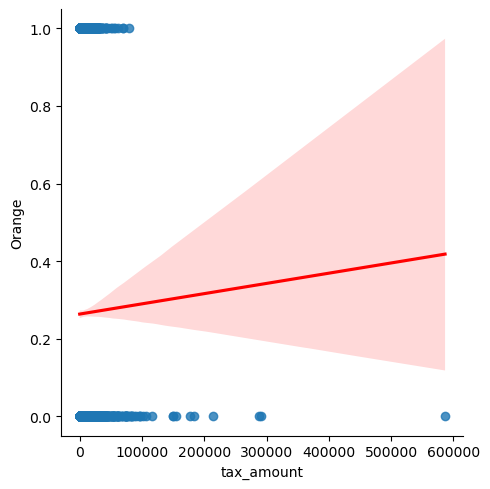

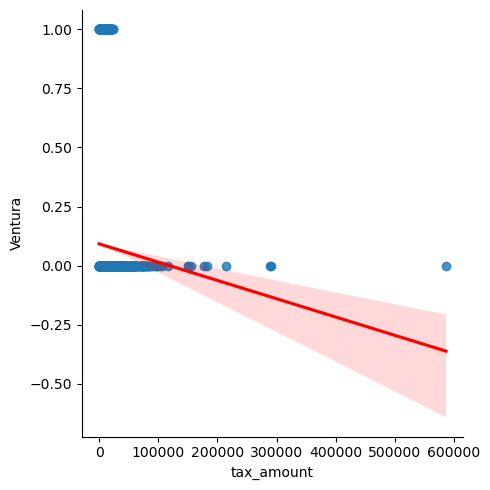

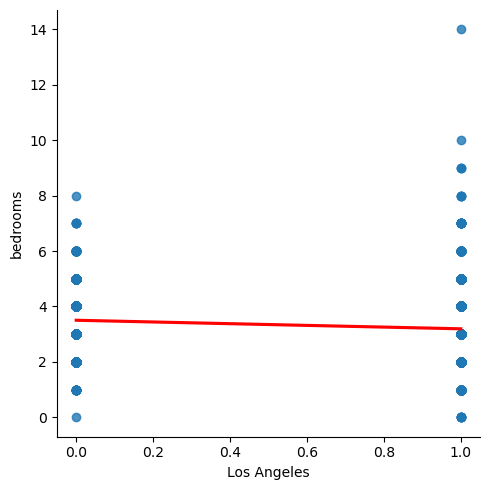

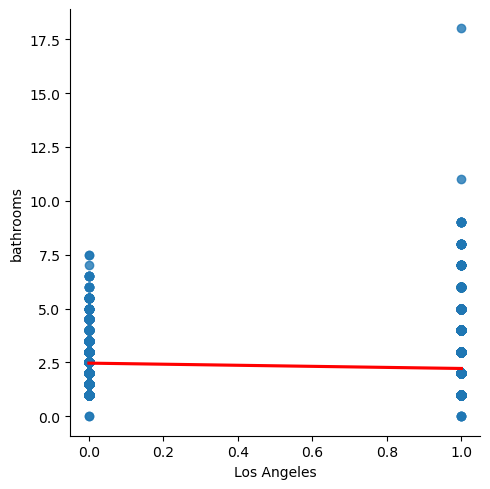

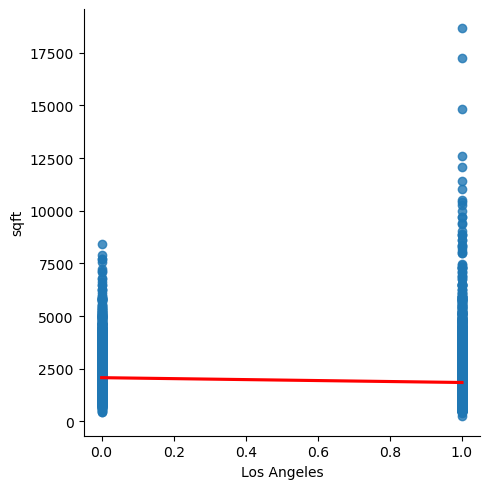

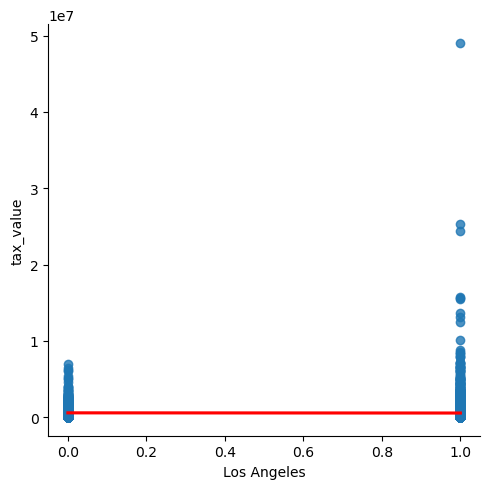

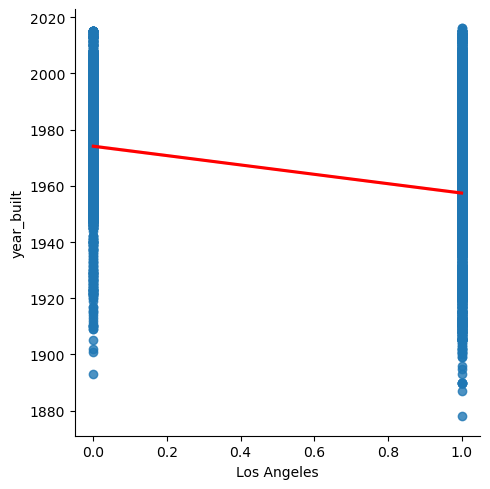

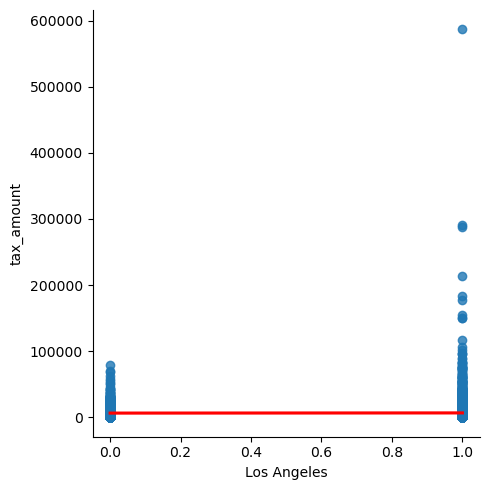

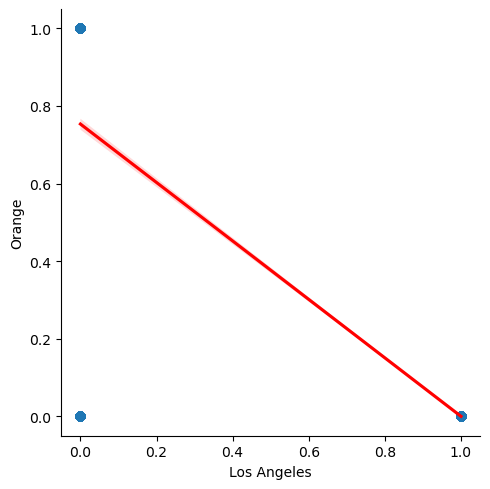

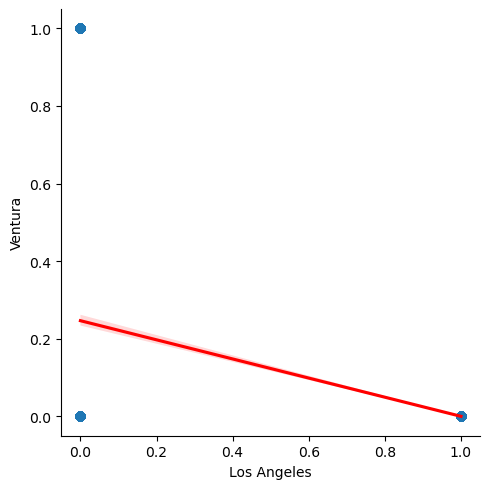

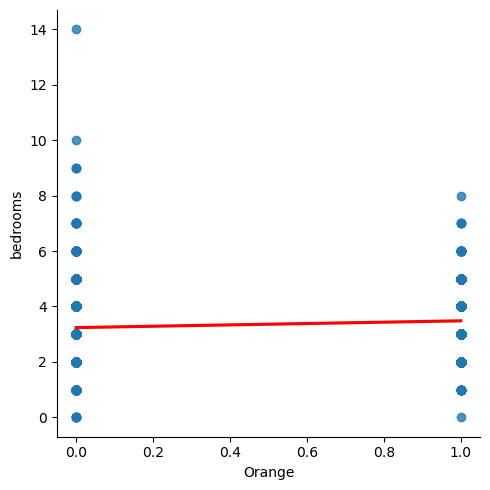

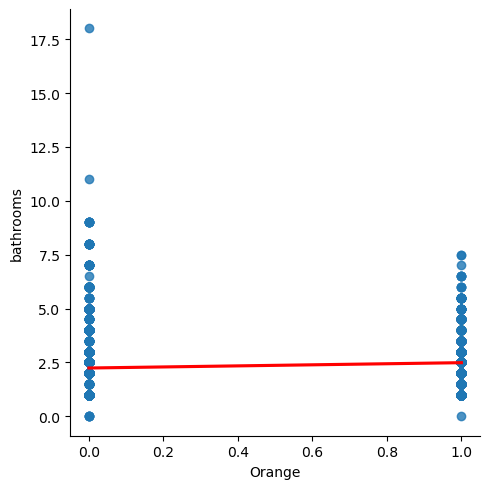

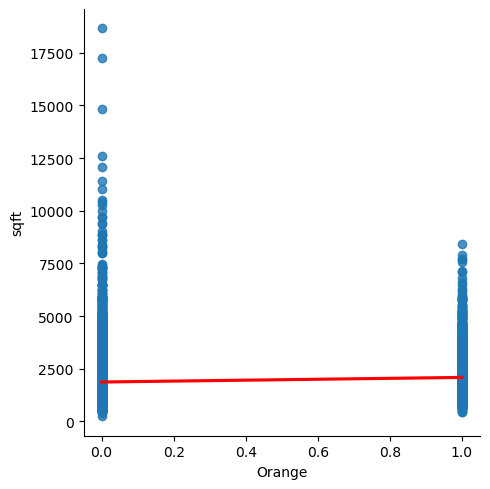

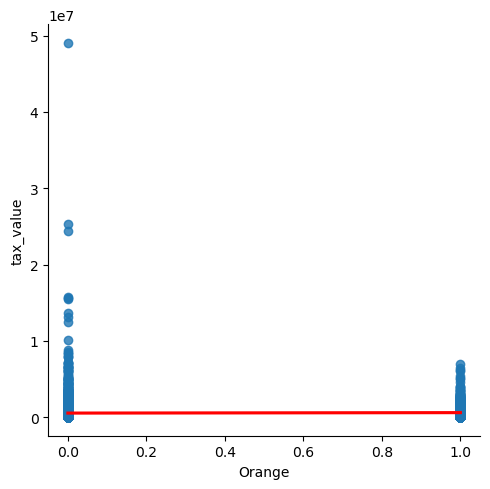

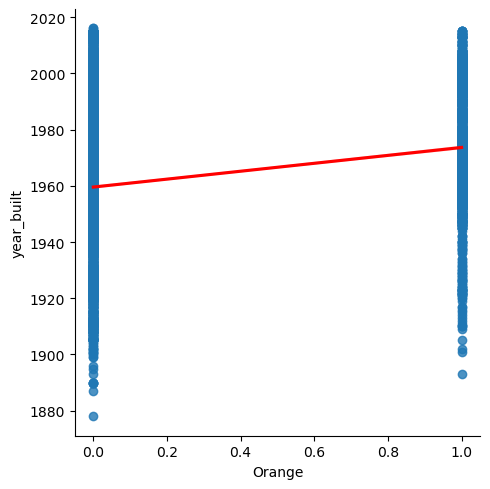

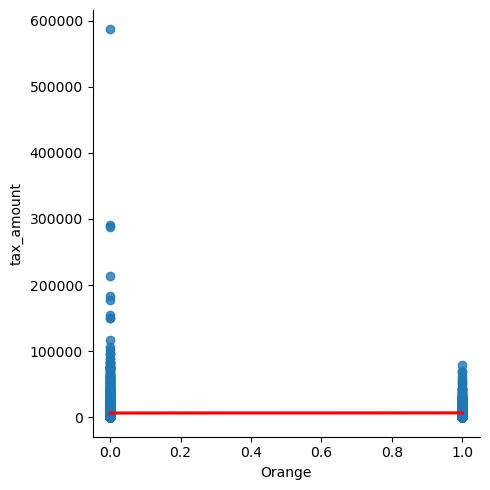

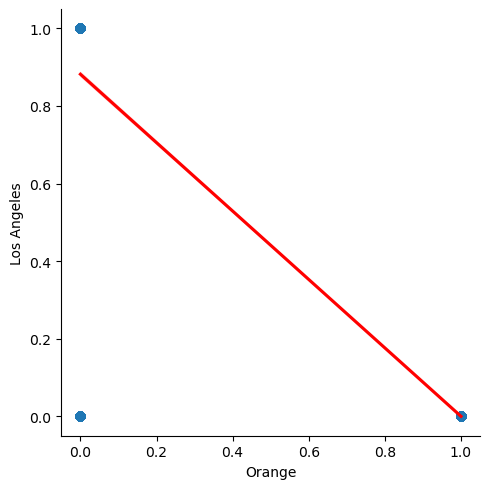

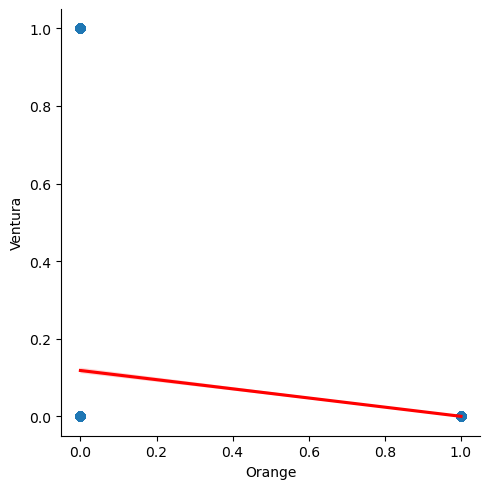

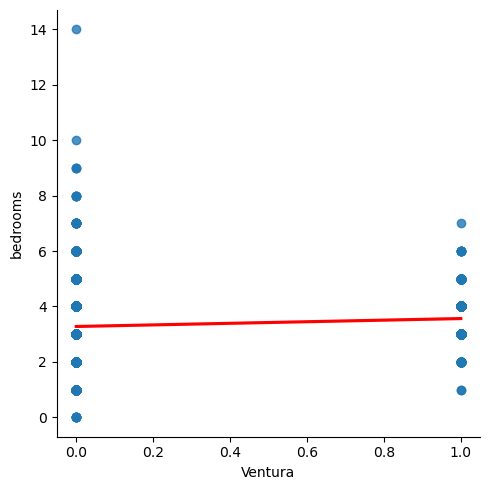

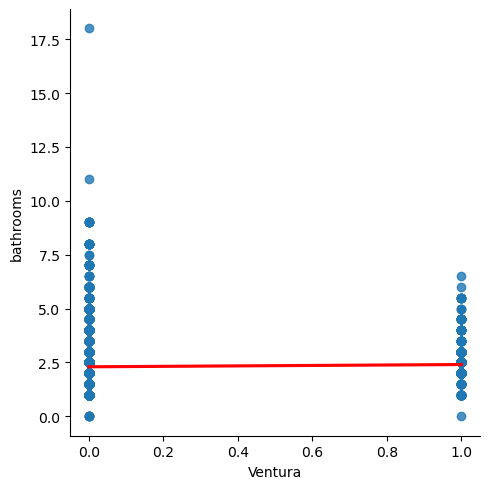

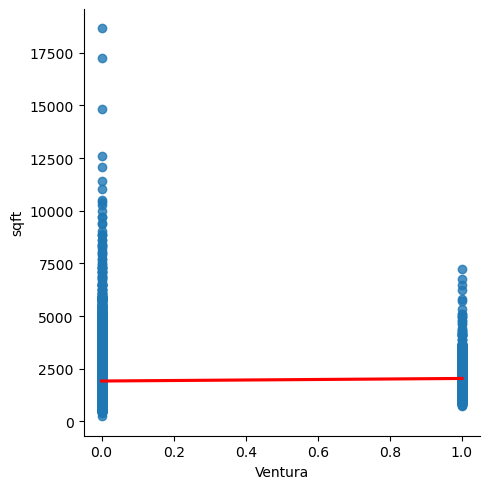

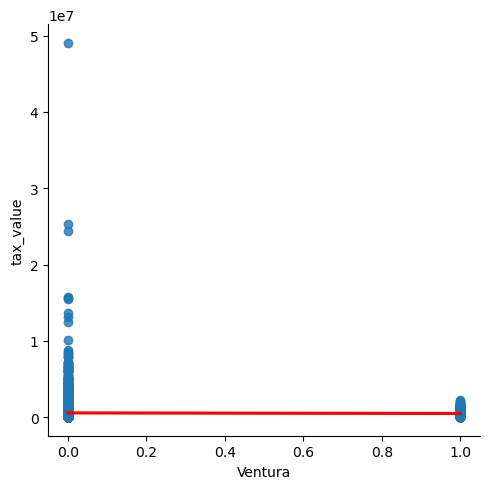

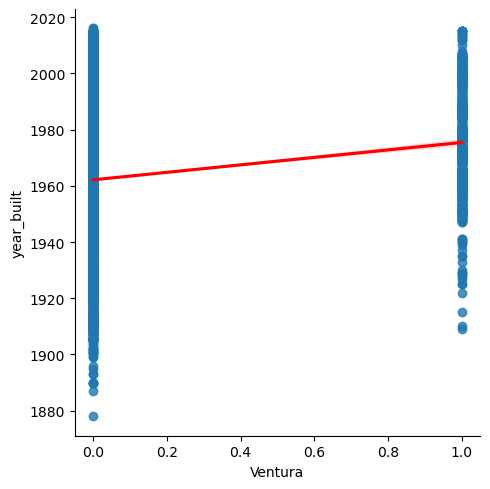

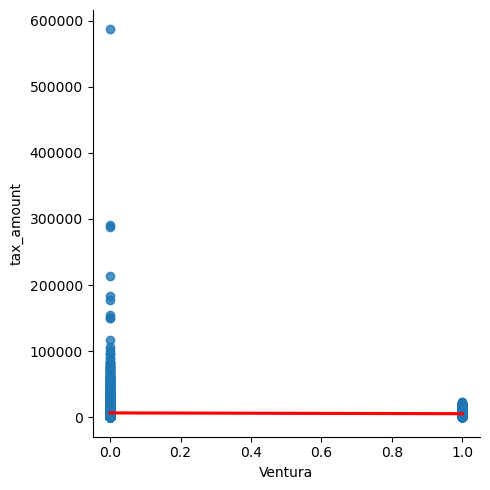

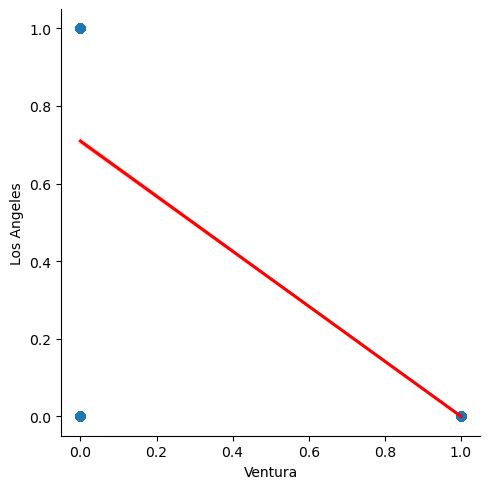

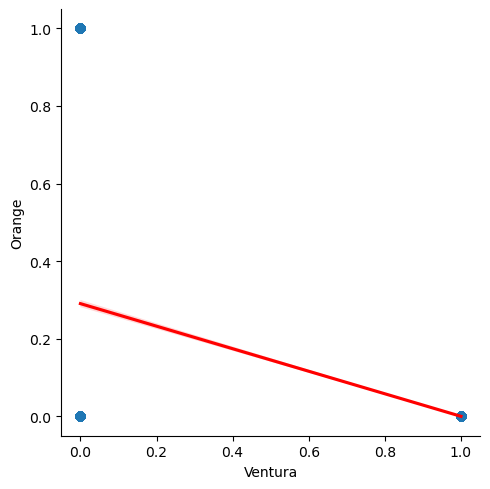

In [22]:
explore.plot_variable_pairs(train)

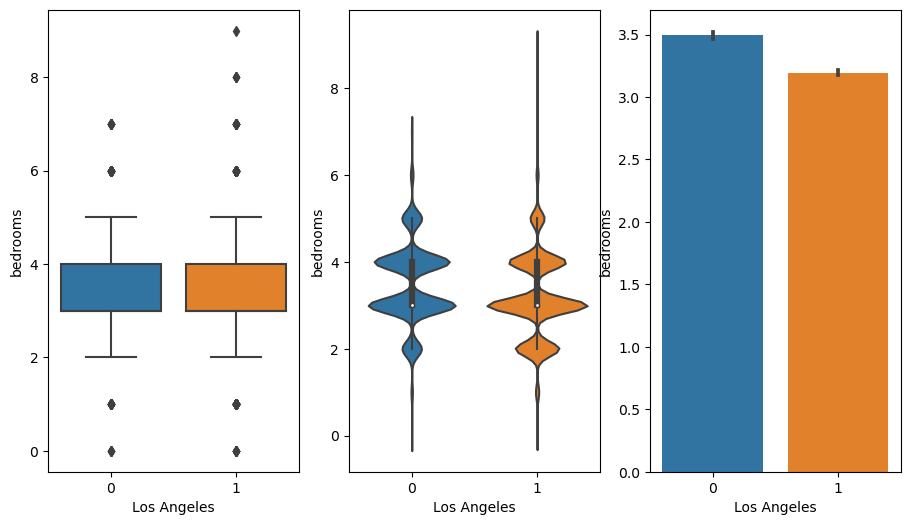

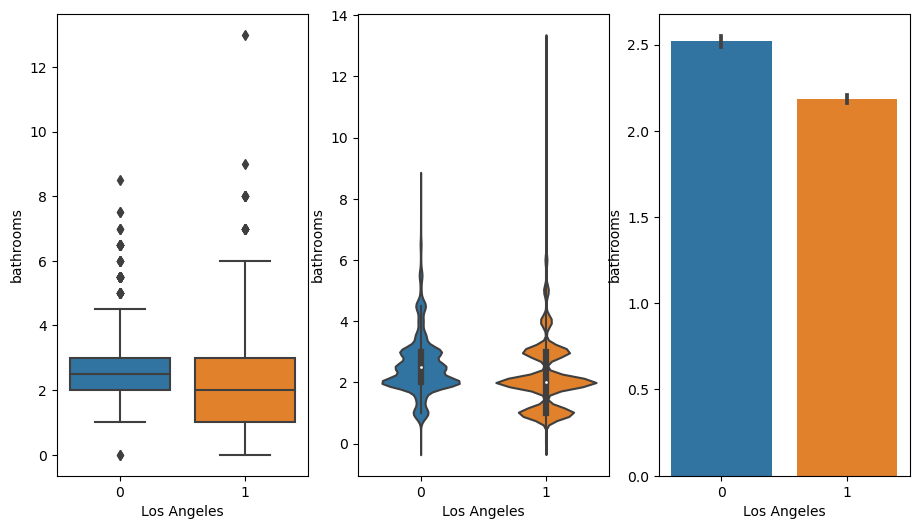

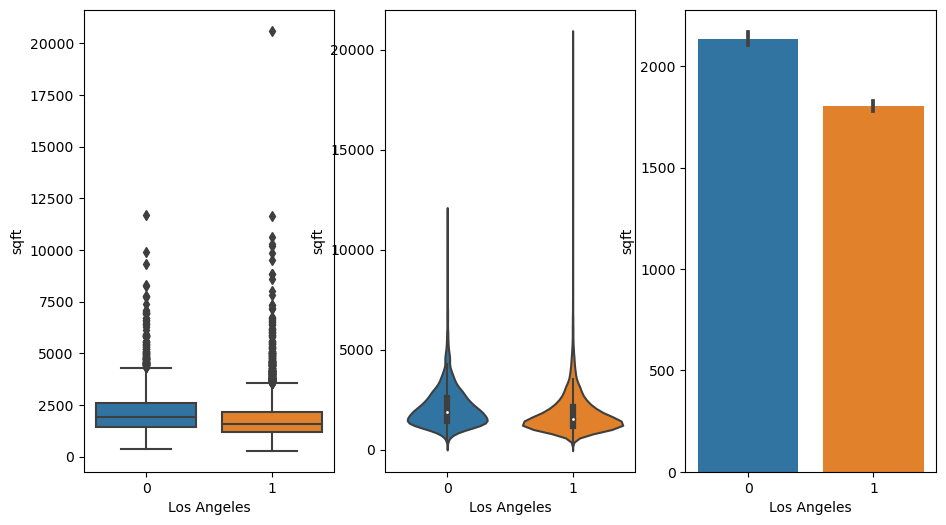

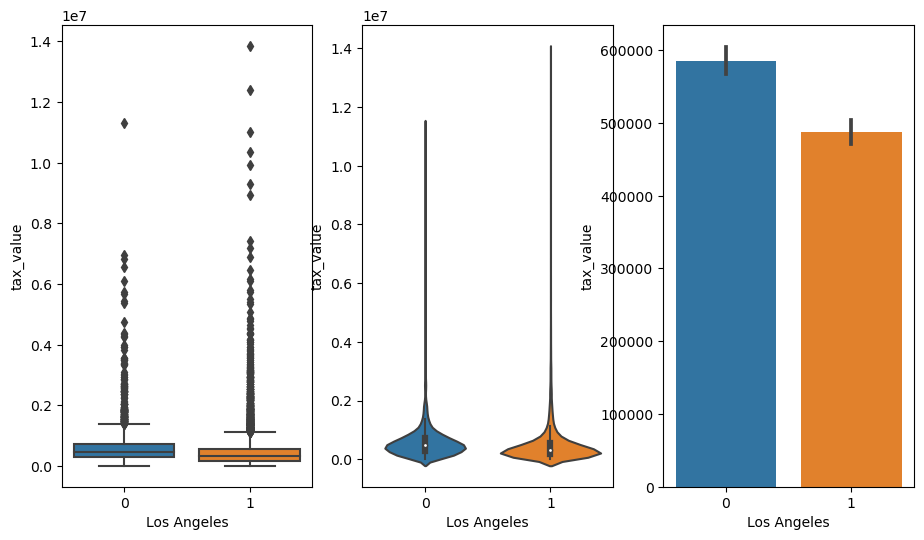

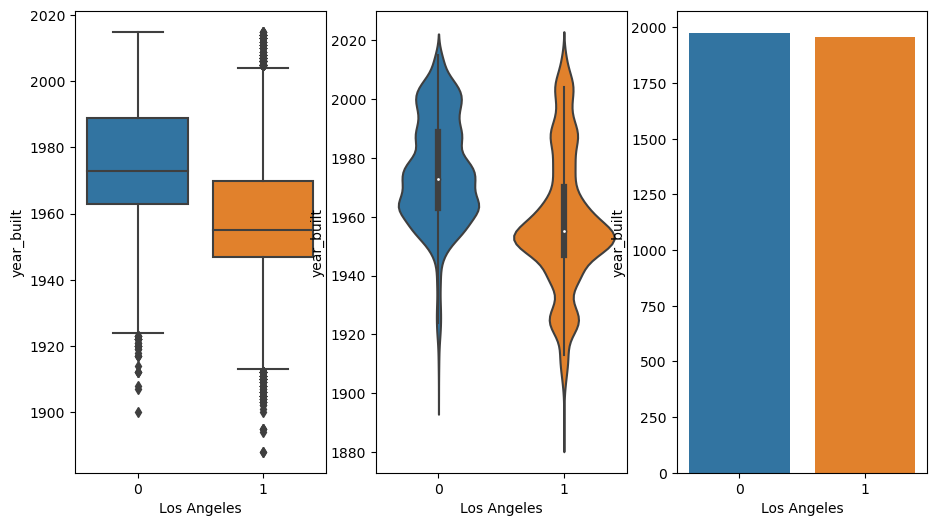

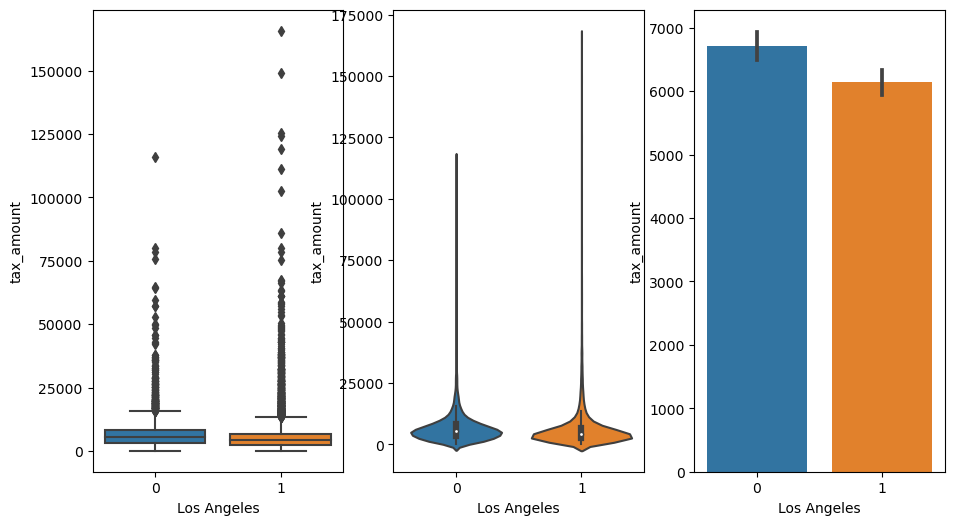

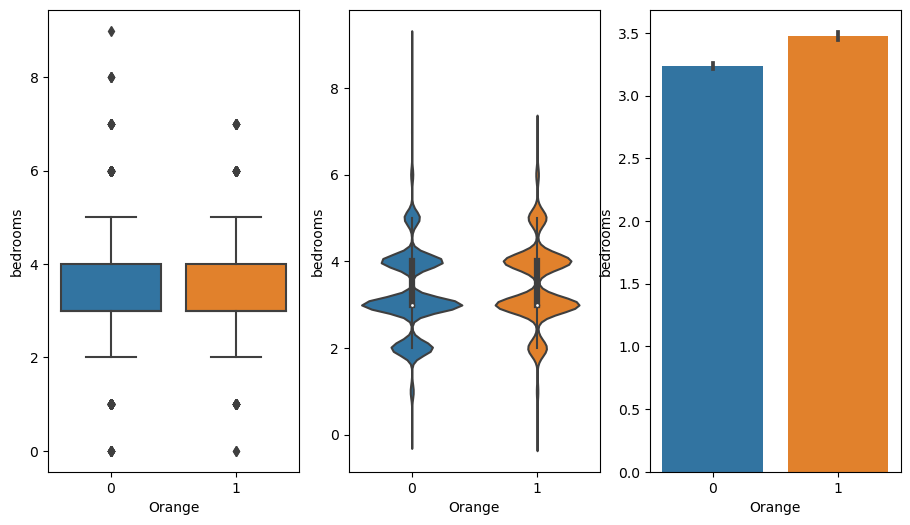

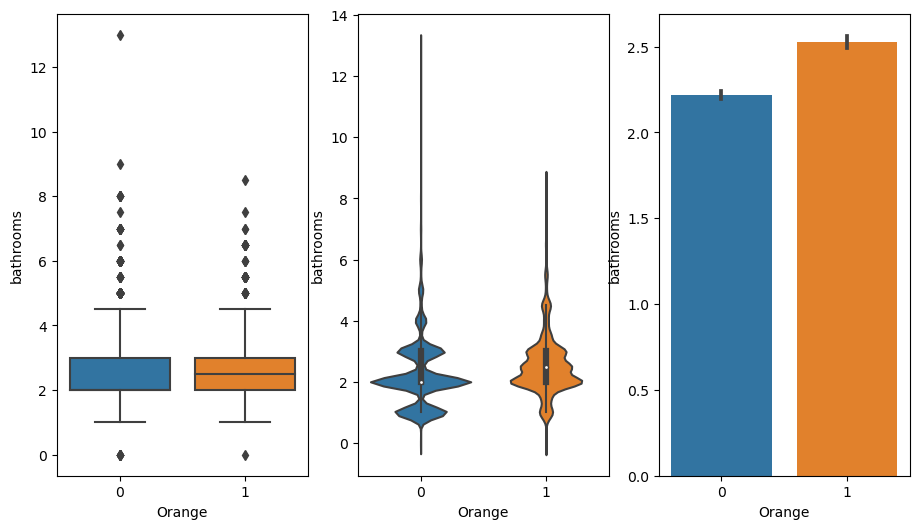

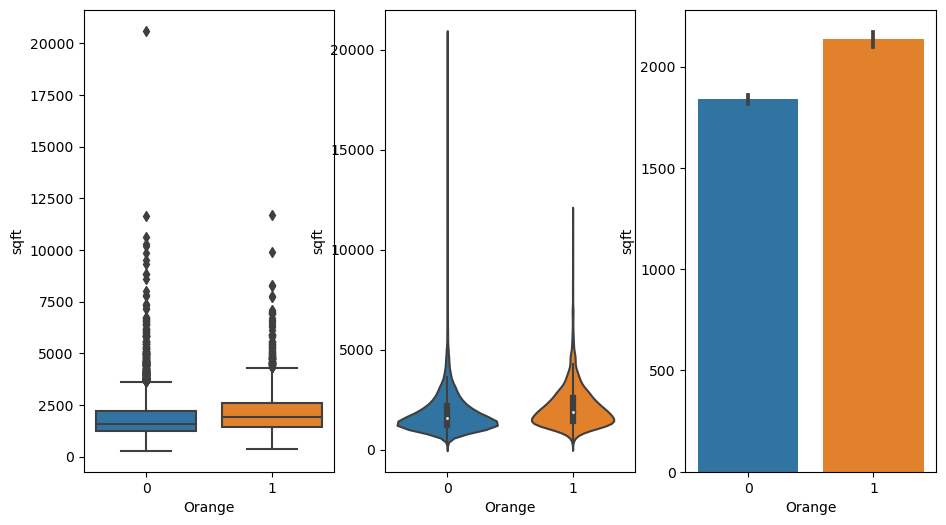

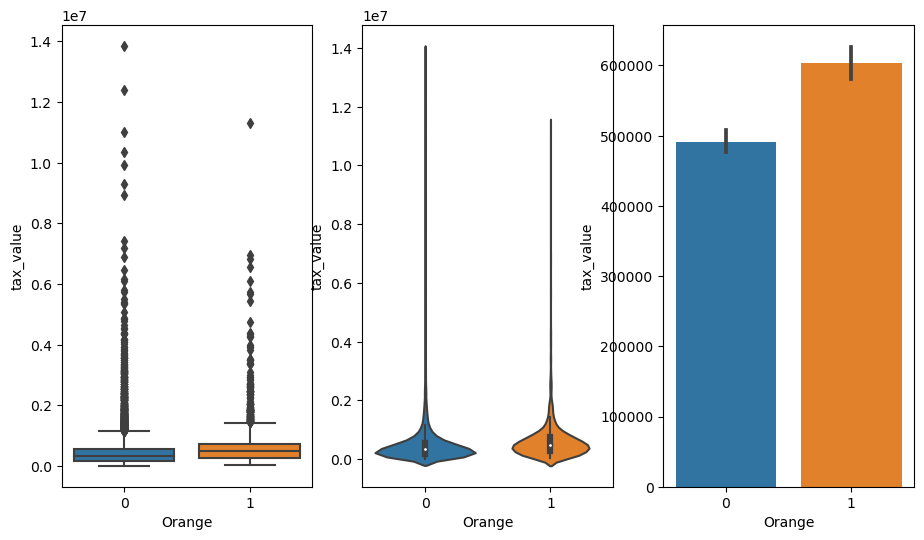

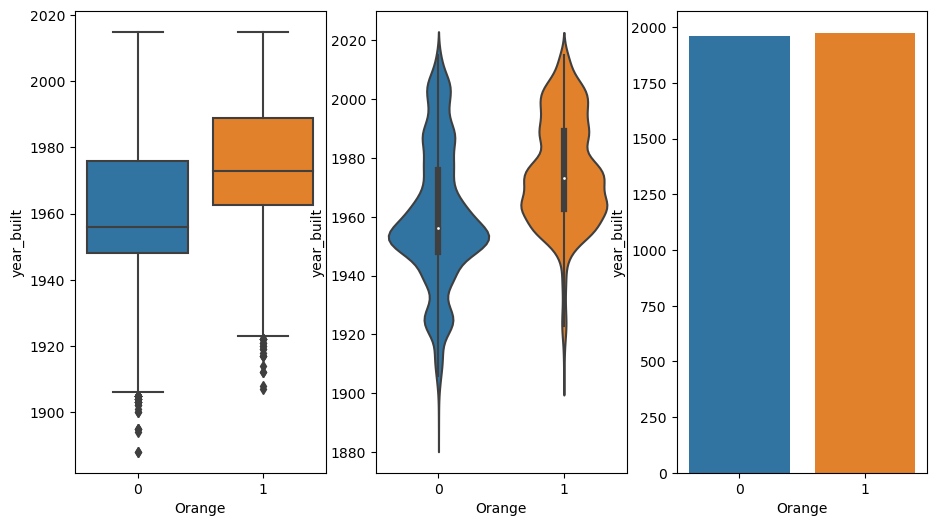

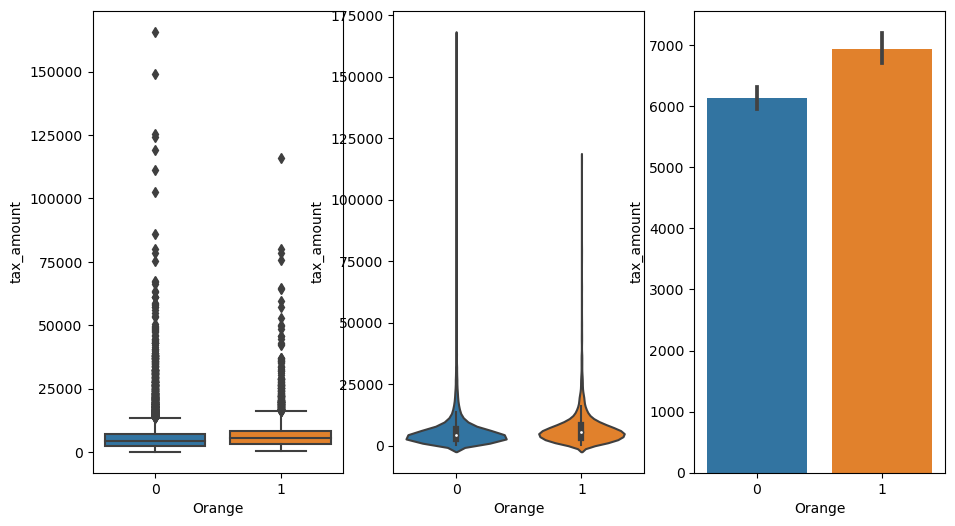

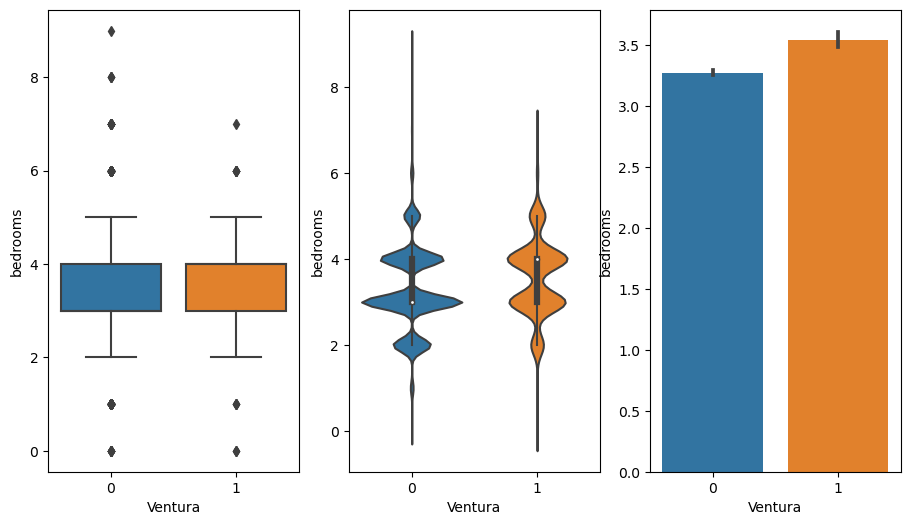

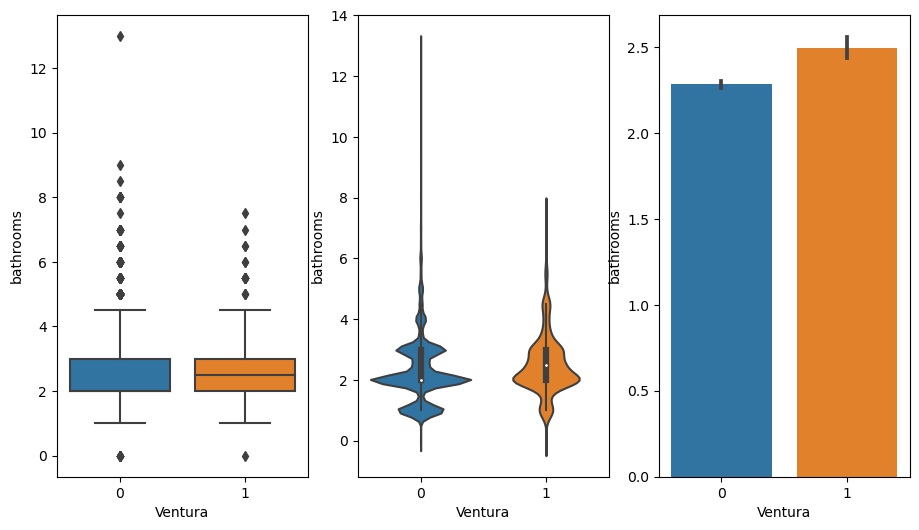

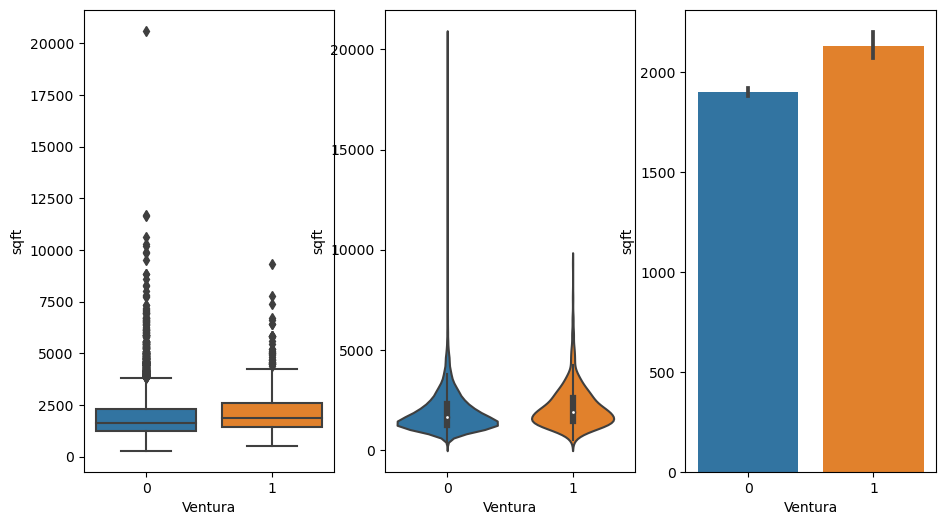

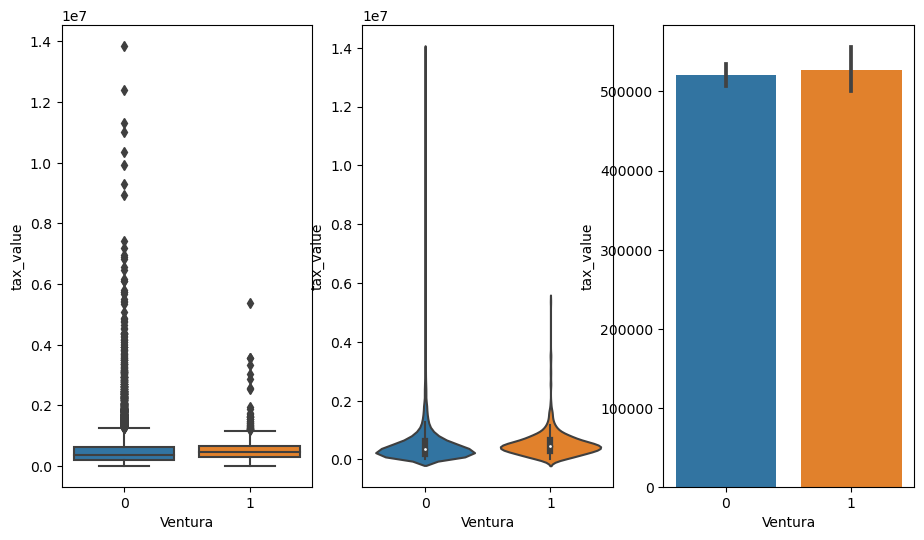

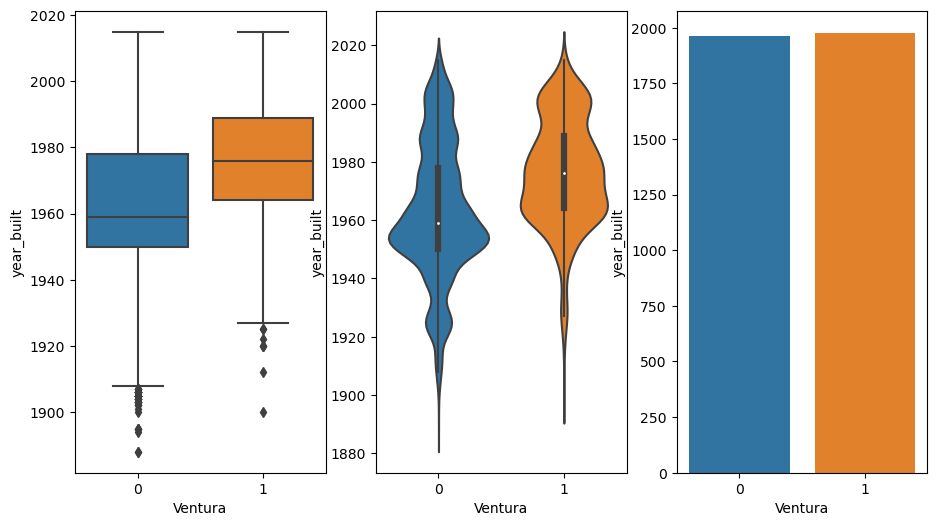

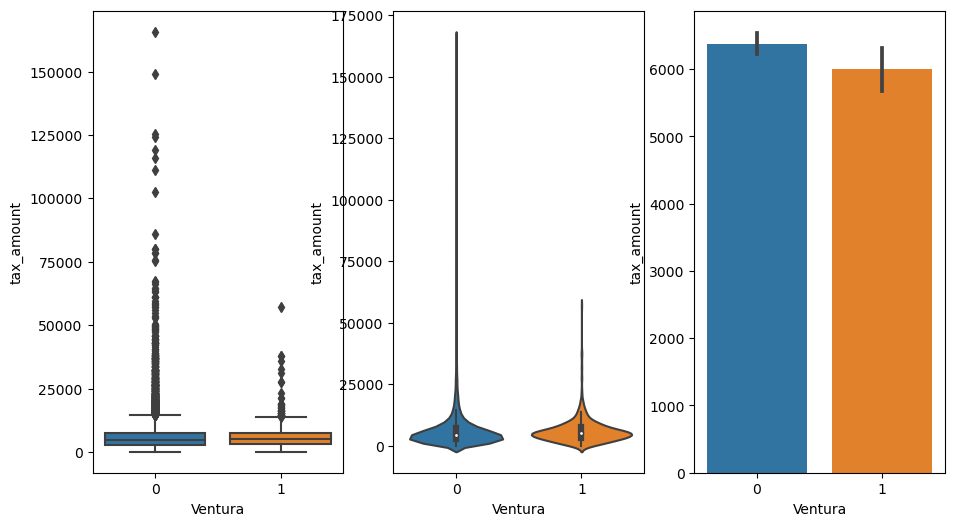

In [24]:
discrete_list = ['Los Angeles', 'Orange', 'Ventura'] #took out fips
continuous_list = ['bedrooms', 'bathrooms', 'sqft', 'tax_value', 'year_built', 'tax_amount']
explore.plot_categorical_and_continuous_vars(zillow_predictions, discrete_list, continuous_list, sample_size=10000)

In [25]:
house_corr = train.corr()
house_corr

,bedrooms,bathrooms,sqft,tax_value,year_built,tax_amount,Los Angeles,Orange,Ventura
bedrooms,1.000000,0.646249,0.634526,0.280090,0.384960,0.281989,-0.150602,0.112226,0.080293
bathrooms,0.646249,1.000000,0.851881,0.517627,0.522008,0.518945,-0.137849,0.120734,0.044672
sqft,0.634526,0.851881,1.000000,0.591913,0.455781,0.591989,-0.135627,0.115376,0.049412
tax_value,0.280090,0.517627,0.591913,1.000000,0.161250,0.990855,-0.044843,0.053705,-0.008557
year_built,0.384960,0.522008,0.455781,0.161250,1.000000,0.165677,-0.359954,0.283641,0.167250
tax_amount,0.281989,0.518945,0.591989,0.990855,0.165677,1.000000,-0.014398,0.028414,-0.020623
Los Angeles,-0.150602,-0.137849,-0.135627,-0.044843,-0.359954,-0.014398,1.000000,-0.821765,-0.410601
Orange,0.112226,0.120734,0.115376,0.053705,0.283641,0.028414,-0.821765,1.000000,-0.182159
Ventura,0.080293,0.044672,0.049412,-0.008557,0.167250,-0.020623,-0.410601,-0.182159,1.000000


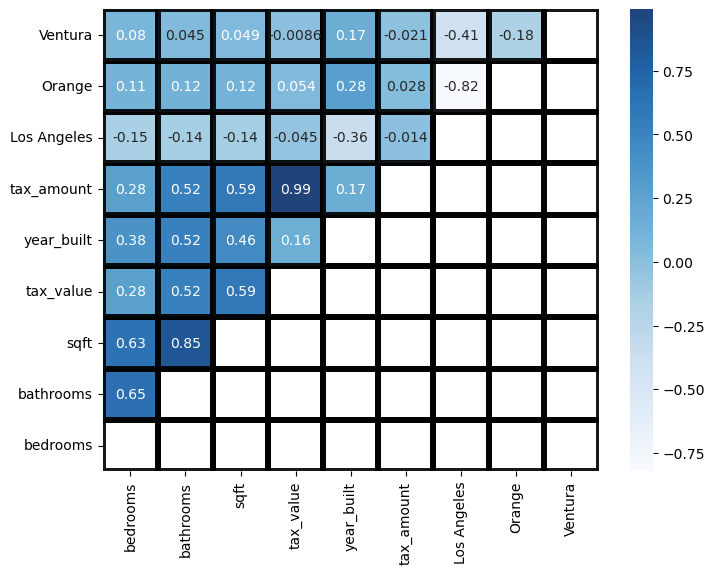

In [68]:
# Pass my correlation matrix to Seaborn's heatmap.

kwargs = {'alpha':.9,'linewidth':3, 'linestyle':'-', 
          'linecolor':'k','rasterized':False, 'edgecolor':'w', 
          'capstyle':'projecting',}

plt.figure(figsize=(8,6))
sns.heatmap(house_corr, cmap='Blues', annot=True, mask= np.triu(house_corr), **kwargs)
plt.ylim(0, 9)

plt.show()


Bathrooms are highly correlated with square feet so for linear regression I will take one out.  Judging by the heat map sqft is better correlated with our target of tax value so that is the one I will keep it over bathrooms and bedrooms in our past MVP.  Year built is also correlated with sqft so i might have another thing to say.  Maybe choose bedrooms and year built.

In [27]:
train_mvp = train.drop(columns=['year_built', 'tax_amount']) #took out fips
validate_mvp = validate.drop(columns=['year_built', 'tax_amount'])
test_mvp = test.drop(columns=['year_built', 'tax_amount'])

X_train_mvp = train_mvp.drop(columns=['tax_value'])
y_train_mvp = train_mvp['tax_value']

X_validate_mvp = validate_mvp.drop(columns=['tax_value'])
y_validate_mvp = validate_mvp['tax_value']

X_test_mvp = test_mvp.drop(columns=['tax_value'])
y_test_mvp = test_mvp['tax_value']

In [28]:
X_train_mvp

,bedrooms,bathrooms,sqft,Los Angeles,Orange,Ventura
3958,3.0,2.0,1600.0,1,0,0
38332,2.0,1.0,1638.0,1,0,0
32297,4.0,2.0,1725.0,1,0,0
31139,2.0,1.0,1015.0,1,0,0
20188,1.0,1.0,565.0,1,0,0
...,...,...,...,...,...,...
35558,4.0,4.0,4226.0,0,0,1
8268,3.0,2.0,1534.0,1,0,0
2175,2.0,1.5,1213.0,0,1,0
11049,3.0,2.0,1584.0,1,0,0


In [35]:
def select_kbest(X, y, n=2):
    f_selector = SelectKBest(f_regression, k=n)
    
    f_selector.fit(X, y)
    
    X_reduced = f_selector.transform(X)
    
    f_support = f_selector.get_support()
    
    f_feature = X.loc[:, f_support].columns.tolist()
    
    print(str(len(f_feature)), 'selected features')
    print(f_feature)
    
select_kbest(X_train_mvp, y_train_mvp, n=3)

3 selected features
['bedrooms', 'bathrooms', 'sqft']


In [36]:
def rfe(X, y, n=2):
    lm = LinearRegression()
    rfe = RFE(lm, n_features_to_select=n)
    
    # Transforming data using RFE
    X_rfe = rfe.fit_transform(X, y) 

    #fit
    lm.fit(X_rfe, y)
    
    mask = rfe.support_
    
    rfe_features = X.loc[:, mask].columns.tolist()

    print(str(len(rfe_features)), 'selected features')
    print(rfe_features)
    
rfe(X_train_mvp, y_train_mvp, n=3)

3 selected features
['Los Angeles', 'Orange', 'Ventura']


This lends further creedence to the guess that these three columns should be combined into one in later linear Regression

In [37]:
# turn series into dataframes to append new columns with predicted values
y_train_mvp = pd.DataFrame(y_train_mvp)
y_validate_mvp = pd.DataFrame(y_validate_mvp)
y_test_mvp = pd.DataFrame(y_test_mvp)

# 1. Predict based on mean
tax_value_pred_mean_mvp = y_train_mvp['tax_value'].mean()
y_train_mvp['tax_value_pred_mean'] = tax_value_pred_mean_mvp
y_validate_mvp['tax_value_pred_mean'] = tax_value_pred_mean_mvp

# 2. Do same for median
tax_value_pred_median_mvp = y_train_mvp['tax_value'].median()
y_train_mvp['tax_value_pred_median'] = tax_value_pred_median_mvp
y_validate_mvp['tax_value_pred_median'] = tax_value_pred_median_mvp

# 3.  RMSE of tax_value_pred_mean
rmse_train_mvp = mean_squared_error(y_train_mvp.tax_value, y_train_mvp.tax_value_pred_mean) ** (1/2)
rmse_validate_mvp = mean_squared_error(y_validate_mvp.tax_value, y_validate_mvp.tax_value_pred_mean) ** (1/2)

print("RMSE using Mean\nTrain/In-Sample: ", round(rmse_train_mvp, 2), 
      "\nValidate/Out-of-Sample: ", round(rmse_validate_mvp, 2)) 

# 4.  RMSE of tax_value_pred_median
rmse_train_mvp = mean_squared_error(y_train_mvp.tax_value, y_train_mvp.tax_value_pred_median) ** (1/2)
rmse_validate_mvp = mean_squared_error(y_validate_mvp.tax_value, y_validate_mvp.tax_value_pred_median) ** (1/2)

print("RMSE using Median\nTrain/In-Sample: ", round(rmse_train_mvp, 2), 
      "\nValidate/Out-of-Sample: ", round(rmse_validate_mvp, 2))

RMSE using Mean
Train/In-Sample:  771278.99 
Validate/Out-of-Sample:  754399.99
RMSE using Median
Train/In-Sample:  786790.28 
Validate/Out-of-Sample:  772208.99


In [38]:
train_mvp

,bedrooms,bathrooms,sqft,tax_value,Los Angeles,Orange,Ventura
3958,3.0,2.0,1600.0,409260.0,1,0,0
38332,2.0,1.0,1638.0,126907.0,1,0,0
32297,4.0,2.0,1725.0,592000.0,1,0,0
31139,2.0,1.0,1015.0,172499.0,1,0,0
20188,1.0,1.0,565.0,292368.0,1,0,0
...,...,...,...,...,...,...,...
35558,4.0,4.0,4226.0,613350.0,0,0,1
8268,3.0,2.0,1534.0,380623.0,1,0,0
2175,2.0,1.5,1213.0,431697.0,0,1,0
11049,3.0,2.0,1584.0,271747.0,1,0,0


In [39]:
#. Create the model object
lm_mvp = LinearRegression()

#. Fit to training and specify column in y_train since it is now a series
lm_mvp.fit(X_train_mvp, y_train_mvp.tax_value)

# predict
y_train_mvp['tax_value_pred_lm'] = lm_mvp.predict(X_train_mvp)

# RMSE
rmse_train_mvp = mean_squared_error(y_train_mvp.tax_value, y_train_mvp.tax_value_pred_lm) ** (1/2)

# predict validate
y_validate_mvp['tax_value_pred_lm'] = lm_mvp.predict(X_validate_mvp)

#Validate RMSE 
rmse_validate_mvp = mean_squared_error(y_validate_mvp.tax_value, y_validate_mvp.tax_value_pred_lm) ** (1/2)

print('RMSE for OLS using LinearRegression\nTraining/In-Sample: ', rmse_train_mvp,
     '\nValidation/Out-of-Sample: ', rmse_validate_mvp)

RMSE for OLS using LinearRegression
Training/In-Sample:  612017.8203430086 
Validation/Out-of-Sample:  582749.8010334001


In [40]:
for i in range(-8,3):
    #. Create the model object
    lars_mvp = LassoLars(alpha=10**i)

    #. Fit to training and specify column in y_train since it is now a series
    lars_mvp.fit(X_train_mvp, y_train_mvp.tax_value)

    # predict
    y_train_mvp['tax_value_pred_lars'] = lars_mvp.predict(X_train_mvp)

    # RMSE
    rmse_train_mvp = mean_squared_error(y_train_mvp.tax_value, y_train_mvp.tax_value_pred_lars) ** (1/2)

    # predict validate
    y_validate_mvp['tax_value_pred_lars'] = lars_mvp.predict(X_validate_mvp)

    #Validate RMSE 
    rmse_validate_mvp = mean_squared_error(y_validate_mvp.tax_value, y_validate_mvp.tax_value_pred_lars) ** (1/2)

    print('RMSE  using LassoLars\nTraining/In-Sample: ', rmse_train_mvp,
         '\nValidation/Out-of-Sample: ', rmse_validate_mvp,
         '\With alpha= 10^', i)

RMSE  using LassoLars
Training/In-Sample:  612017.8203430086 
Validation/Out-of-Sample:  582749.8010333999 \With alpha= 10^ -8
RMSE  using LassoLars
Training/In-Sample:  612017.8203430086 
Validation/Out-of-Sample:  582749.8010333999 \With alpha= 10^ -7
RMSE  using LassoLars
Training/In-Sample:  612017.8203430086 
Validation/Out-of-Sample:  582749.801033369 \With alpha= 10^ -6
RMSE  using LassoLars
Training/In-Sample:  612017.8203430086 
Validation/Out-of-Sample:  582749.8010330909 \With alpha= 10^ -5
RMSE  using LassoLars
Training/In-Sample:  612017.8203430086 
Validation/Out-of-Sample:  582749.8010303112 \With alpha= 10^ -4
RMSE  using LassoLars
Training/In-Sample:  612017.8203430086 
Validation/Out-of-Sample:  582749.8010025126 \With alpha= 10^ -3
RMSE  using LassoLars
Training/In-Sample:  612017.8203430101 
Validation/Out-of-Sample:  582749.8007245277 \With alpha= 10^ -2
RMSE  using LassoLars
Training/In-Sample:  612017.8203431724 
Validation/Out-of-Sample:  582749.7979448318 \With

In [41]:
for i in range(0,4):
    # create the model object
    glm_mvp = TweedieRegressor(power=i, alpha=0)

    # fit the model to our training data. We must specify the column in y_train, 
    # since we have converted it to a dataframe from a series! 
    glm_mvp.fit(X_train_mvp, y_train_mvp.tax_value)

    # predict train
    y_train_mvp['tax_value_pred_glm'] = glm_mvp.predict(X_train_mvp)

    # evaluate: rmse
    rmse_train_mvp = mean_squared_error(y_train_mvp.tax_value, y_train_mvp.tax_value_pred_glm)**(1/2)

    # predict validate
    y_validate_mvp['tax_value_pred_glm'] = glm_mvp.predict(X_validate_mvp)

    # evaluate: rmse
    rmse_validate_mvp = mean_squared_error(y_validate_mvp.tax_value, y_validate_mvp.tax_value_pred_glm)**(1/2)

    print("RMSE for GLM using Tweedie, power=", i, " & alpha=0\nTraining/In-Sample: ", rmse_train_mvp, 
          "\nValidation/Out-of-Sample: ", rmse_validate_mvp)

RMSE for GLM using Tweedie, power= 0  & alpha=0
Training/In-Sample:  612096.5349217121 
Validation/Out-of-Sample:  582871.9746467929
RMSE for GLM using Tweedie, power= 1  & alpha=0
Training/In-Sample:  771278.9894738657 
Validation/Out-of-Sample:  754399.9850390545
RMSE for GLM using Tweedie, power= 2  & alpha=0
Training/In-Sample:  13308486.801904347 
Validation/Out-of-Sample:  77951820.28557715
RMSE for GLM using Tweedie, power= 3  & alpha=0
Training/In-Sample:  742894.8076528817 
Validation/Out-of-Sample:  721764.9901702399


/usr/local/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_glm/glm.py:284: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)
/usr/local/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_linear_loss.py:289: RuntimeWarning: invalid value encountered in matmul
  grad[:n_features] = X.T @ grad_pointwise + l2_reg_strength * weights
/usr/local/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_glm/glm.py:284: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)


In [42]:
for i in range(0,5):
    # make the polynomial features to get a new set of features
    pf_mvp = PolynomialFeatures(degree=i)

    # fit and transform X_train_scaled
    X_train_degree2_mvp = pf_mvp.fit_transform(X_train_mvp)

    # transform X_validate_scaled & X_test_scaled
    X_validate_degree2_mvp = pf_mvp.transform(X_validate_mvp)
    X_test_degree2_mvp = pf_mvp.transform(X_test_mvp)

    # create the model object
    lm2_mvp = LinearRegression()

    # fit the model to our training data. We must specify the column in y_train, 
    # since we have converted it to a dataframe from a series! 
    lm2_mvp.fit(X_train_degree2_mvp, y_train_mvp.tax_value)

    # predict train
    y_train_mvp['tax_value_pred_poly'] = lm2_mvp.predict(X_train_degree2_mvp)

    # evaluate: rmse
    rmse_train_mvp = mean_squared_error(y_train_mvp.tax_value, y_train_mvp.tax_value_pred_poly)**(1/2)

    # predict validate
    y_validate_mvp['tax_value_pred_poly'] = lm2_mvp.predict(X_validate_degree2_mvp)

    # evaluate: rmse
    rmse_validate_mvp = mean_squared_error(y_validate_mvp.tax_value, y_validate_mvp.tax_value_pred_poly)**(1/2)

    print("RMSE for Polynomial Model, degrees=", i, "\nTraining/In-Sample: ", rmse_train_mvp, 
          "\nValidation/Out-of-Sample: ", rmse_validate_mvp)

RMSE for Polynomial Model, degrees= 0 
Training/In-Sample:  771278.9894738657 
Validation/Out-of-Sample:  754399.9850390545
RMSE for Polynomial Model, degrees= 1 
Training/In-Sample:  612017.8203430086 
Validation/Out-of-Sample:  582749.8010333996
RMSE for Polynomial Model, degrees= 2 
Training/In-Sample:  552256.3705779964 
Validation/Out-of-Sample:  562682.7144393248
RMSE for Polynomial Model, degrees= 3 
Training/In-Sample:  535829.2593209737 
Validation/Out-of-Sample:  627246.4814460446
RMSE for Polynomial Model, degrees= 4 
Training/In-Sample:  539197.4454948837 
Validation/Out-of-Sample:  942432.8517332848


In [45]:
train = train.drop(columns=['tax_amount']) #took out fips
validate = validate.drop(columns=['tax_amount'])
test = test.drop(columns=['tax_amount'])

X_train = train.drop(columns=['tax_value'])
y_train = train['tax_value']

X_validate = validate.drop(columns=['tax_value'])
y_validate = validate['tax_value']

X_test = test.drop(columns=['tax_value'])
y_test = test['tax_value']

In [46]:
train

,bedrooms,bathrooms,sqft,tax_value,year_built,Los Angeles,Orange,Ventura
3958,3.0,2.0,1600.0,409260.0,1959.0,1,0,0
38332,2.0,1.0,1638.0,126907.0,1927.0,1,0,0
32297,4.0,2.0,1725.0,592000.0,1966.0,1,0,0
31139,2.0,1.0,1015.0,172499.0,1925.0,1,0,0
20188,1.0,1.0,565.0,292368.0,1915.0,1,0,0
...,...,...,...,...,...,...,...,...
35558,4.0,4.0,4226.0,613350.0,1959.0,0,0,1
8268,3.0,2.0,1534.0,380623.0,1970.0,1,0,0
2175,2.0,1.5,1213.0,431697.0,1956.0,0,1,0
11049,3.0,2.0,1584.0,271747.0,1959.0,1,0,0


In [47]:
# turn series into dataframes to append new columns with predicted values
y_train = pd.DataFrame(y_train)
y_validate = pd.DataFrame(y_validate)
y_test = pd.DataFrame(y_test)

# 1. Predict based on mean
tax_value_pred_mean = y_train['tax_value'].mean()
y_train['tax_value_pred_mean'] = tax_value_pred_mean
y_validate['tax_value_pred_mean'] = tax_value_pred_mean

# 2. Do same for median
tax_value_pred_median = y_train['tax_value'].median()
y_train['tax_value_pred_median'] = tax_value_pred_median
y_validate['tax_value_pred_median'] = tax_value_pred_median

# 3.  RMSE of tax_value_pred_mean
rmse_train = mean_squared_error(y_train.tax_value, y_train.tax_value_pred_mean) ** (1/2)
rmse_validate = mean_squared_error(y_validate.tax_value, y_validate.tax_value_pred_mean) ** (1/2)

print("RMSE using Mean\nTrain/In-Sample: ", round(rmse_train, 2), 
      "\nValidate/Out-of-Sample: ", round(rmse_validate, 2)) 

# 4.  RMSE of tax_value_pred_median
rmse_train = mean_squared_error(y_train.tax_value, y_train.tax_value_pred_median) ** (1/2)
rmse_validate = mean_squared_error(y_validate.tax_value, y_validate.tax_value_pred_median) ** (1/2)

print("RMSE using Median\nTrain/In-Sample: ", round(rmse_train, 2), 
      "\nValidate/Out-of-Sample: ", round(rmse_validate, 2))

RMSE using Mean
Train/In-Sample:  771278.99 
Validate/Out-of-Sample:  754399.99
RMSE using Median
Train/In-Sample:  786790.28 
Validate/Out-of-Sample:  772208.99


In [48]:
#. Create the model object
lm = LinearRegression()

#. Fit to training and specify column in y_train since it is now a series
lm.fit(X_train, y_train.tax_value)

# predict
y_train['tax_value_pred_lm'] = lm.predict(X_train)

# RMSE
rmse_train = mean_squared_error(y_train.tax_value, y_train.tax_value_pred_lm) ** (1/2)

# predict validate
y_validate['tax_value_pred_lm'] = lm.predict(X_validate)

#Validate RMSE 
rmse_validate = mean_squared_error(y_validate.tax_value, y_validate.tax_value_pred_lm) ** (1/2)

print('RMSE for OLS using LinearRegression\nTraining/In-Sample: ', rmse_train,
     '\nValidation/Out-of-Sample: ', rmse_validate)

RMSE for OLS using LinearRegression
Training/In-Sample:  604558.4441072997 
Validation/Out-of-Sample:  576375.5574853255


In [49]:
for i in range(-8,3):
    #. Create the model object
    lars = LassoLars(alpha=10**i)

    #. Fit to training and specify column in y_train since it is now a series
    lars.fit(X_train, y_train.tax_value)

    # predict
    y_train['tax_value_pred_lars'] = lars.predict(X_train)

    # RMSE
    rmse_train = mean_squared_error(y_train.tax_value, y_train.tax_value_pred_lars) ** (1/2)

    # predict validate
    y_validate['tax_value_pred_lars'] = lars.predict(X_validate)

    #Validate RMSE 
    rmse_validate = mean_squared_error(y_validate.tax_value, y_validate.tax_value_pred_lars) ** (1/2)

    print('RMSE  using LassoLars\nTraining/In-Sample: ', rmse_train,
         '\nValidation/Out-of-Sample: ', rmse_validate,
         '\With alpha= 10^', i)

RMSE  using LassoLars
Training/In-Sample:  604558.4441072997 
Validation/Out-of-Sample:  576375.5574853256 \With alpha= 10^ -8
RMSE  using LassoLars
Training/In-Sample:  604558.4441072997 
Validation/Out-of-Sample:  576375.5574853256 \With alpha= 10^ -7
RMSE  using LassoLars
Training/In-Sample:  604558.4441072997 
Validation/Out-of-Sample:  576375.5574852992 \With alpha= 10^ -6
RMSE  using LassoLars
Training/In-Sample:  604558.4441072997 
Validation/Out-of-Sample:  576375.5574850606 \With alpha= 10^ -5
RMSE  using LassoLars
Training/In-Sample:  604558.4441072997 
Validation/Out-of-Sample:  576375.5574826754 \With alpha= 10^ -4
RMSE  using LassoLars
Training/In-Sample:  604558.4441072997 
Validation/Out-of-Sample:  576375.5574588244 \With alpha= 10^ -3
RMSE  using LassoLars
Training/In-Sample:  604558.4441073015 
Validation/Out-of-Sample:  576375.5572203147 \With alpha= 10^ -2
RMSE  using LassoLars
Training/In-Sample:  604558.444107485 
Validation/Out-of-Sample:  576375.5548353945 \With

In [50]:
for i in range(0,4):
    # create the model object
    glm = TweedieRegressor(power=i, alpha=0)

    # fit the model to our training data. We must specify the column in y_train, 
    # since we have converted it to a dataframe from a series! 
    glm.fit(X_train, y_train.tax_value)

    # predict train
    y_train['tax_value_pred_glm'] = glm.predict(X_train)

    # evaluate: rmse
    rmse_train = mean_squared_error(y_train.tax_value, y_train.tax_value_pred_glm)**(1/2)

    # predict validate
    y_validate['tax_value_pred_glm'] = glm.predict(X_validate)

    # evaluate: rmse
    rmse_validate = mean_squared_error(y_validate.tax_value, y_validate.tax_value_pred_glm)**(1/2)

    print("RMSE for GLM using Tweedie, power=", i, " & alpha=0\nTraining/In-Sample: ", rmse_train, 
          "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for GLM using Tweedie, power= 0  & alpha=0
Training/In-Sample:  611024.6054551152 
Validation/Out-of-Sample:  581836.6385978691
RMSE for GLM using Tweedie, power= 1  & alpha=0
Training/In-Sample:  771278.9894738657 
Validation/Out-of-Sample:  754399.9850390545
RMSE for GLM using Tweedie, power= 2  & alpha=0
Training/In-Sample:  14977092.02202358 
Validation/Out-of-Sample:  77261806.71199286
RMSE for GLM using Tweedie, power= 3  & alpha=0
Training/In-Sample:  29791373.856070925 
Validation/Out-of-Sample:  276262390.1032238


/usr/local/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_glm/glm.py:284: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)
/usr/local/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_linear_loss.py:289: RuntimeWarning: invalid value encountered in matmul
  grad[:n_features] = X.T @ grad_pointwise + l2_reg_strength * weights
/usr/local/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_glm/glm.py:284: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)


In [51]:
for i in range(0,5):
    # make the polynomial features to get a new set of features
    pf = PolynomialFeatures(degree=i)

    # fit and transform X_train_scaled
    X_train_degree2 = pf.fit_transform(X_train)

    # transform X_validate_scaled & X_test_scaled
    X_validate_degree2 = pf.transform(X_validate)
    X_test_degree2 = pf.transform(X_test)

    # create the model object
    lm2 = LinearRegression()

    # fit the model to our training data. We must specify the column in y_train, 
    # since we have converted it to a dataframe from a series! 
    lm2.fit(X_train_degree2, y_train.tax_value)

    # predict train
    y_train['tax_value_pred_poly'] = lm2.predict(X_train_degree2)

    # evaluate: rmse
    rmse_train = mean_squared_error(y_train.tax_value, y_train.tax_value_pred_poly)**(1/2)

    # predict validate
    y_validate['tax_value_pred_poly'] = lm2.predict(X_validate_degree2)

    # evaluate: rmse
    rmse_validate = mean_squared_error(y_validate.tax_value, y_validate.tax_value_pred_poly)**(1/2)

    print("RMSE for Polynomial Model, degrees=", i, "\nTraining/In-Sample: ", rmse_train, 
          "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for Polynomial Model, degrees= 0 
Training/In-Sample:  771278.9894738657 
Validation/Out-of-Sample:  754399.9850390545
RMSE for Polynomial Model, degrees= 1 
Training/In-Sample:  604558.4441072997 
Validation/Out-of-Sample:  576375.5574853257
RMSE for Polynomial Model, degrees= 2 
Training/In-Sample:  543878.2221674434 
Validation/Out-of-Sample:  556103.2994130312
RMSE for Polynomial Model, degrees= 3 
Training/In-Sample:  531841.3789266776 
Validation/Out-of-Sample:  619816.5421937834
RMSE for Polynomial Model, degrees= 4 
Training/In-Sample:  522597.76216170116 
Validation/Out-of-Sample:  928859.6570345873


In [53]:
def scale_zillow(df):
    # Split the Data
    train_validate, test = train_test_split(df, test_size = .2, random_state=823)
    train, validate = train_test_split(train_validate, test_size= .25, random_state=823)
    
    X_train = train.drop(columns=['year_built', 'tax_amount', 'tax_value'])#took out fips
    y_train_scaled = pd.DataFrame(train['tax_value'])

    X_validate = validate.drop(columns=['year_built', 'tax_amount', 'tax_value'])
    y_validate_scaled = pd.DataFrame(validate['tax_value'])

    X_test = test.drop(columns=['year_built', 'tax_amount', 'tax_value'])
    y_test_scaled = pd.DataFrame(test['tax_value'])
    
    #Set the Scaler
    scaler = sklearn.preprocessing.MinMaxScaler()
    # Note that we only call .fit with the training data,
    # but we use .transform to apply the scaling to all the data splits.
    scaler.fit(X_train)

    # Turn all the sets inot the scaled np data array
    X_train_scaled = scaler.transform(X_train)
    X_validate_scaled = scaler.transform(X_validate)
    X_test_scaled = scaler.transform(X_test)
    
    # Create a dictionary so that I can take the np arrays back to a labelled pd DataFrame
    columns = train.columns #List of Columns
    numbers = [0,1,2,3,4,5,6] #List of numbers for the scaled np array I'm converting into a dataframe
    zipped= dict(zip(numbers, columns))

    
    #turn the Train Validate and Test arrays back into labelled DataFrames
    X_train_scaled = pd.DataFrame(X_train_scaled).rename(columns=zipped)
    X_validate_scaled = pd.DataFrame(X_validate_scaled).rename(columns=zipped)
    X_test_scaled = pd.DataFrame(X_test_scaled).rename(columns=zipped)
    
    #Return the three scaled DataFrames
    return X_train_scaled, X_validate_scaled, X_test_scaled, y_train_scaled, y_validate_scaled, y_test_scaled

X_train_scaled, X_validate_scaled, X_test_scaled, y_train_scaled, y_validate_scaled, y_test_scaled = scale_zillow(zillow_predictions)

Scaled Data

In [54]:
# scaler = sklearn.preprocessing.MinMaxScaler()
# # Note that we only call .fit with the training data,
# # but we use .transform to apply the scaling to all the data splits.
# scaler.fit(train)

# train_scaled = pd.DataFrame(scaler.transform(train))
# validate_scaled = pd.DataFrame(scaler.transform(validate))
# test_scaled = pd.DataFrame(scaler.transform(test))

# columns = train.columns #List of Columns
# numbers = [0,1,2,3,4,5,6] #List of numbers for the scaled np array I'm converting into a dataframe
# zipped= dict(zip(numbers, columns))
# train_scaled = pd.DataFrame(train_scaled).rename(columns=zipped)
# validate_scaled = pd.DataFrame(validate_scaled).rename(columns=zipped)
# test_scaled = pd.DataFrame(test_scaled).rename(columns=zipped)
# train_scaled = train_scaled.drop(columns=['tax_amount', 'fips'])
# validate_scaled = validate_scaled.drop(columns=['tax_amount', 'fips'])
# test_scaled = test_scaled.drop(columns=['tax_amount', 'fips'])

# X_train_scaled = train_scaled.drop(columns=['year_built', 'tax_amount','fips'])
# y_train_scaled = train_scaled['tax_value']

# X_validate_scaled = validate_scaled.drop(columns=['year_built', 'tax_amount','fips'])
# y_validate_scaled = validate_scaled['tax_value']

# X_test_scaled = test_scaled.drop(columns=['year_built', 'tax_amount','fips'])
# y_test_scaled = test_scaled['tax_value']


In [55]:
X_train_scaled

,bedrooms,bathrooms,sqft,tax_value,year_built,tax_amount
0,0.214286,0.111111,0.079456,1.0,0.0,0.0
1,0.142857,0.055556,0.081507,1.0,0.0,0.0
2,0.285714,0.111111,0.086203,1.0,0.0,0.0
3,0.142857,0.055556,0.047879,1.0,0.0,0.0
4,0.071429,0.055556,0.023588,1.0,0.0,0.0
...,...,...,...,...,...,...
31305,0.285714,0.222222,0.221203,0.0,0.0,1.0
31306,0.214286,0.111111,0.075893,1.0,0.0,0.0
31307,0.142857,0.083333,0.058566,0.0,1.0,0.0
31308,0.214286,0.111111,0.078592,1.0,0.0,0.0


In [56]:
# turn series into dataframes to append new columns with predicted values
y_train_scaled = pd.DataFrame(y_train_scaled)
y_validate_scaled = pd.DataFrame(y_validate_scaled)
y_test_scaled = pd.DataFrame(y_test_scaled)

# 1. Predict based on mean
tax_value_pred_mean_scaled = y_train_scaled['tax_value'].mean()
y_train_scaled['tax_value_pred_mean'] = tax_value_pred_mean_scaled
y_validate_scaled['tax_value_pred_mean'] = tax_value_pred_mean_scaled

# 2. Do same for median
tax_value_pred_median_scaled = y_train_scaled['tax_value'].median()
y_train_scaled['tax_value_pred_median'] = tax_value_pred_median_scaled
y_validate_scaled['tax_value_pred_median'] = tax_value_pred_median_scaled

# 3.  RMSE of tax_value_pred_mean
rmse_train_scaled = mean_squared_error(y_train_scaled.tax_value, y_train_scaled.tax_value_pred_mean) ** (1/2)
rmse_validate_scaled = mean_squared_error(y_validate_scaled.tax_value, y_validate_scaled.tax_value_pred_mean) ** (1/2)

print("RMSE using Mean\nTrain/In-Sample: ", round(rmse_train_scaled, 2), 
      "\nValidate/Out-of-Sample: ", round(rmse_validate_scaled, 2)) 

# 4.  RMSE of tax_value_pred_median
rmse_train_scaled = mean_squared_error(y_train_scaled.tax_value, y_train_scaled.tax_value_pred_median) ** (1/2)
rmse_validate_scaled = mean_squared_error(y_validate_scaled.tax_value, y_validate_scaled.tax_value_pred_median) ** (1/2)

print("RMSE using Median\nTrain/In-Sample: ", round(rmse_train_scaled, 2), 
      "\nValidate/Out-of-Sample: ", round(rmse_validate_scaled, 2))

RMSE using Mean
Train/In-Sample:  771278.99 
Validate/Out-of-Sample:  754399.99
RMSE using Median
Train/In-Sample:  786790.28 
Validate/Out-of-Sample:  772208.99


In [57]:
RMSE using Mean
Train/In-Sample:  771278.99 
Validate/Out-of-Sample:  754399.99
RMSE using Median
Train/In-Sample:  786790.28 
Validate/Out-of-Sample:  772208.99

SyntaxError: invalid syntax (1818781246.py, line 1)

In [60]:
#. Create the model object
lm_scaled = LinearRegression()

#. Fit to training and specify column in y_train since it is now a series
lm_scaled.fit(X_train_scaled, y_train_scaled.tax_value)

# predict
y_train_scaled['tax_value_pred_lm'] = lm_scaled.predict(X_train_scaled)

# RMSE
rmse_train_scaled = mean_squared_error(y_train_scaled.tax_value, y_train_scaled.tax_value_pred_lm) ** (1/2)

# predict validate
y_validate_scaled['tax_value_pred_lm'] = lm_scaled.predict(X_validate_scaled)

#Validate RMSE 
rmse_validate_scaled = mean_squared_error(y_validate_scaled.tax_value, y_validate_scaled.tax_value_pred_lm) ** (1/2)

print('RMSE for OLS using LinearRegression\nTraining/In-Sample: ', rmse_train_scaled,
     '\nValidation/Out-of-Sample: ', rmse_validate_scaled)

RMSE for OLS using LinearRegression
Training/In-Sample:  612017.8203430086 
Validation/Out-of-Sample:  582749.8010333999


In [61]:
RMSE for OLS using LinearRegression
Training/In-Sample:  612564.764222483 
Validation/Out-of-Sample:  583368.8305481623

SyntaxError: invalid syntax (32730217.py, line 1)

In [62]:
for i in range(-8,3):
    #. Create the model object
    lars_scaled = LassoLars(alpha=10**i)

    #. Fit to training and specify column in y_train since it is now a series
    lars_scaled.fit(X_train_scaled, y_train_scaled.tax_value)

    # predict
    y_train_scaled['tax_value_pred_lars'] = lars_scaled.predict(X_train_scaled)

    # RMSE
    rmse_train_scaled = mean_squared_error(y_train_scaled.tax_value, y_train_scaled.tax_value_pred_lars) ** (1/2)

    # predict validate
    y_validate_scaled['tax_value_pred_lars'] = lars_scaled.predict(X_validate_scaled)

    #Validate RMSE 
    rmse_validate_scaled = mean_squared_error(y_validate_scaled.tax_value, y_validate_scaled.tax_value_pred_lars) ** (1/2)

    print('RMSE  using LassoLars\nTraining/In-Sample: ', rmse_train_scaled,
         '\nValidation/Out-of-Sample: ', rmse_validate_scaled,
         '\With alpha= 10^', i)

RMSE  using LassoLars
Training/In-Sample:  612017.8203430086 
Validation/Out-of-Sample:  582749.8010333999 \With alpha= 10^ -8
RMSE  using LassoLars
Training/In-Sample:  612017.8203430086 
Validation/Out-of-Sample:  582749.8010333999 \With alpha= 10^ -7
RMSE  using LassoLars
Training/In-Sample:  612017.8203430086 
Validation/Out-of-Sample:  582749.8010332391 \With alpha= 10^ -6
RMSE  using LassoLars
Training/In-Sample:  612017.8203430085 
Validation/Out-of-Sample:  582749.8010317928 \With alpha= 10^ -5
RMSE  using LassoLars
Training/In-Sample:  612017.8203430086 
Validation/Out-of-Sample:  582749.8010173283 \With alpha= 10^ -4
RMSE  using LassoLars
Training/In-Sample:  612017.8203430099 
Validation/Out-of-Sample:  582749.8008726852 \With alpha= 10^ -3
RMSE  using LassoLars
Training/In-Sample:  612017.8203431485 
Validation/Out-of-Sample:  582749.7994263916 \With alpha= 10^ -2
RMSE  using LassoLars
Training/In-Sample:  612017.8203570046 
Validation/Out-of-Sample:  582749.784977128 \With

In [63]:
RMSE  using LassoLars
Training/In-Sample:  612564.764222483 
Validation/Out-of-Sample:  583368.8305481623 \With alpha= 10^ -8
RMSE  using LassoLars
Training/In-Sample:  612564.764222483 
Validation/Out-of-Sample:  583368.8305481623 \With alpha= 10^ -7
RMSE  using LassoLars
Training/In-Sample:  612564.764222483 
Validation/Out-of-Sample:  583368.8305481205 \With alpha= 10^ -6
RMSE  using LassoLars
Training/In-Sample:  612564.764222483 
Validation/Out-of-Sample:  583368.8305477442 \With alpha= 10^ -5
RMSE  using LassoLars
Training/In-Sample:  612564.764222483 
Validation/Out-of-Sample:  583368.8305439816 \With alpha= 10^ -4
RMSE  using LassoLars
Training/In-Sample:  612564.764222483 
Validation/Out-of-Sample:  583368.8305063556 \With alpha= 10^ -3
RMSE  using LassoLars
Training/In-Sample:  612564.7642224836 
Validation/Out-of-Sample:  583368.8301300964 \With alpha= 10^ -2
RMSE  using LassoLars
Training/In-Sample:  612564.7642225422 
Validation/Out-of-Sample:  583368.8263675596 \With alpha= 10^ -1
RMSE  using LassoLars
Training/In-Sample:  612564.764228398 
Validation/Out-of-Sample:  583368.7887477387 \With alpha= 10^ 0
RMSE  using LassoLars
Training/In-Sample:  612564.7648139801 
Validation/Out-of-Sample:  583368.4131042674 \With alpha= 10^ 1
RMSE  using LassoLars
Training/In-Sample:  612564.8233721848 
Validation/Out-of-Sample:  583364.7121437612 \With alpha= 10^ 2

SyntaxError: invalid syntax (519083573.py, line 1)

In [64]:
for i in range(0,4):
    # create the model object
    glm_scaled = TweedieRegressor(power=i, alpha=0)

    # fit the model to our training data. We must specify the column in y_train, 
    # since we have converted it to a dataframe from a series! 
    glm_scaled.fit(X_train_scaled, y_train_scaled.tax_value)

    # predict train
    y_train_scaled['tax_value_pred_glm'] = glm_scaled.predict(X_train_scaled)

    # evaluate: rmse
    rmse_train_scaled = mean_squared_error(y_train_scaled.tax_value, y_train_scaled.tax_value_pred_glm)**(1/2)

    # predict validate
    y_validate_scaled['tax_value_pred_glm'] = glm_scaled.predict(X_validate_scaled)

    # evaluate: rmse
    rmse_validate_scaled = mean_squared_error(y_validate_scaled.tax_value, y_validate_scaled.tax_value_pred_glm)**(1/2)

    print("RMSE for GLM using Tweedie, power=", i, " & alpha=0\nTraining/In-Sample: ", rmse_train_scaled, 
          "\nValidation/Out-of-Sample: ", rmse_validate_scaled)

RMSE for GLM using Tweedie, power= 0  & alpha=0
Training/In-Sample:  612017.8203430088 
Validation/Out-of-Sample:  582749.8008208338
RMSE for GLM using Tweedie, power= 1  & alpha=0
Training/In-Sample:  984112.6234417382 
Validation/Out-of-Sample:  1752759.6945091398
RMSE for GLM using Tweedie, power= 2  & alpha=0
Training/In-Sample:  13319758.963709297 
Validation/Out-of-Sample:  75691815.07148618
RMSE for GLM using Tweedie, power= 3  & alpha=0
Training/In-Sample:  771278.9894738657 
Validation/Out-of-Sample:  754399.9850390545


In [65]:
RMSE for GLM using Tweedie, power= 0  & alpha=0
Training/In-Sample:  612564.764222483 
Validation/Out-of-Sample:  583368.8305483744
RMSE for GLM using Tweedie, power= 1  & alpha=0
Training/In-Sample:  771278.9894738657 
Validation/Out-of-Sample:  754399.9850390545
RMSE for GLM using Tweedie, power= 2  & alpha=0
Training/In-Sample:  14659537.529494978 
Validation/Out-of-Sample:  81489206.77304138
RMSE for GLM using Tweedie, power= 3  & alpha=0
Training/In-Sample:  742894.8080743523 
Validation/Out-of-Sample:  721764.9906588517

SyntaxError: invalid syntax (4129243497.py, line 1)

In [66]:
for i in range(0,5):
    # make the polynomial features to get a new set of features
    pf_scaled = PolynomialFeatures(degree=i)

    # fit and transform X_train_scaled
    X_train_degree2_scaled = pf_scaled.fit_transform(X_train_scaled)

    # transform X_validate_scaled & X_test_scaled
    X_validate_degree2_scaled = pf_scaled.transform(X_validate_scaled)
    X_test_degree2_scaled = pf_scaled.transform(X_test_scaled)

    # create the model object
    lm2_scaled = LinearRegression()

    # fit the model to our training data. We must specify the column in y_train, 
    # since we have converted it to a dataframe from a series! 
    lm2_scaled.fit(X_train_degree2_scaled, y_train_scaled.tax_value)

    # predict train
    y_train_scaled['tax_value_pred_poly'] = lm2_scaled.predict(X_train_degree2_scaled)

    # evaluate: rmse
    rmse_train_scaled = mean_squared_error(y_train_scaled.tax_value, y_train_scaled.tax_value_pred_poly)**(1/2)

    # predict validate
    y_validate_scaled['tax_value_pred_poly'] = lm2_scaled.predict(X_validate_degree2_scaled)

    # evaluate: rmse
    rmse_validate_scaled = mean_squared_error(y_validate_scaled.tax_value, y_validate_scaled.tax_value_pred_poly)**(1/2)

    print("RMSE for Polynomial Model, degrees=", i, "\nTraining/In-Sample: ", rmse_train_scaled, 
          "\nValidation/Out-of-Sample: ", rmse_validate_scaled)
    

RMSE for Polynomial Model, degrees= 0 
Training/In-Sample:  771278.9894738657 
Validation/Out-of-Sample:  754399.9850390545
RMSE for Polynomial Model, degrees= 1 
Training/In-Sample:  612017.8203430085 
Validation/Out-of-Sample:  582749.8010334002
RMSE for Polynomial Model, degrees= 2 
Training/In-Sample:  552256.3705952802 
Validation/Out-of-Sample:  562682.7327462428
RMSE for Polynomial Model, degrees= 3 
Training/In-Sample:  535829.2593200994 
Validation/Out-of-Sample:  627246.57399188
RMSE for Polynomial Model, degrees= 4 
Training/In-Sample:  531378.7072641742 
Validation/Out-of-Sample:  940016.1571175155


In [67]:
RMSE for Polynomial Model, degrees= 0 
Training/In-Sample:  771278.9894738657 
Validation/Out-of-Sample:  754399.9850390545
RMSE for Polynomial Model, degrees= 1 
Training/In-Sample:  612564.764222483 
Validation/Out-of-Sample:  583368.8305481619
RMSE for Polynomial Model, degrees= 2 
Training/In-Sample:  553884.4782982081 
Validation/Out-of-Sample:  564390.3121042952
RMSE for Polynomial Model, degrees= 3 
Training/In-Sample:  538250.3458132704 
Validation/Out-of-Sample:  616249.54483675
RMSE for Polynomial Model, degrees= 4 
Training/In-Sample:  535615.6168697184 
Validation/Out-of-Sample:  720517.7152769017

SyntaxError: invalid syntax (1378494958.py, line 1)